In [1]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

[Taichi] version 0.8.1, llvm 10.0.0, commit cc2dd342, linux, python 3.9.7
[TaiGLSL] version 0.0.11


In [ ]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'wysiwyp'],
                                        ['depth1', 'depth2', 'depth3'],
                                        ['alpha1', 'alpha2', 'alpha3'],
                                        ['sorted1','sorted2','sorted3'],
                                        ['diff1','diff2','diff3']], figsize=(15,25))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['rgb'].set_axis_off()
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['alpha'].set_axis_off()
    axs['wysiwyp'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    axs['wysiwyp'].set_axis_off()    
    
    axs['depth1'].imshow(im.squeeze()[[4]].permute(1,2,0).cpu().numpy())
    axs['depth1'].set_title('Interval 1')
    axs['depth1'].set_axis_off()
    axs['depth2'].imshow(im.squeeze()[[5]].permute(1,2,0).cpu().numpy())
    axs['depth2'].set_title('Interval 2')
    axs['depth2'].set_axis_off()
    axs['depth3'].imshow(im.squeeze()[[6]].permute(1,2,0).cpu().numpy())
    axs['depth3'].set_title('Interval 3')
    axs['depth3'].set_axis_off()
    axs['alpha1'].imshow(im.squeeze()[[7]].permute(1,2,0).cpu().numpy())
    axs['alpha1'].set_title('Alpha at I1')
    axs['alpha1'].set_axis_off()
    axs['alpha2'].imshow(im.squeeze()[[8]].permute(1,2,0).cpu().numpy())
    axs['alpha2'].set_title('Alpha at I2')
    axs['alpha2'].set_axis_off()
    axs['alpha3'].imshow(im.squeeze()[[9]].permute(1,2,0).cpu().numpy())
    axs['alpha3'].set_title('Alpha at I3')
    axs['alpha3'].set_axis_off()

    
    sorted_depth, idx = rgbad[4:7].sort(dim=0)
    axs['sorted1'].imshow(sorted_depth[[0]].permute(1,2,0).cpu().numpy())
    axs['sorted1'].set_title('Sorted Depth 1')
    axs['sorted1'].set_axis_off()
    axs['sorted2'].imshow(sorted_depth[[1]].permute(1,2,0).cpu().numpy())
    axs['sorted2'].set_title('Sorted Depth 2')
    axs['sorted2'].set_axis_off()
    axs['sorted3'].imshow(sorted_depth[[2]].permute(1,2,0).cpu().numpy())
    axs['sorted3'].set_title('Sorted Depth 3')
    axs['sorted3'].set_axis_off()
    
    if 'diff1' in axs:
        diff1 = sorted_depth[1] - sorted_depth[0]
        diff2 = sorted_depth[2] - sorted_depth[1]
        diff3 = sorted_depth[2] - sorted_depth[0]
        axs['diff1'].imshow(diff1[None].permute(1,2,0).cpu().numpy())
        axs['diff1'].set_title('Sorted 2 - 1')
        axs['diff1'].set_axis_off()
        axs['diff2'].imshow(diff2[None].permute(1,2,0).cpu().numpy())
        axs['diff2'].set_title('Sorted 3 - 2')
        axs['diff2'].set_axis_off()
        axs['diff3'].imshow(diff3[None].permute(1,2,0).cpu().numpy())
        axs['diff3'].set_title('Sorted 3 - 1')
        axs['diff3'].set_axis_off()
    
    
    
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [4]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate

out_dir = Path('/run/media/dome/Cluster/STDepth_data_multi')
ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
# ds = TorchDataset('/mnt/hdd/shared_datasets/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [2]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': 3,
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

In [3]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0).detach().cpu()
rgbad_full[4:][(rgbad_full[4:] == 0.0)] = 1.0
show_im(rgbad_full)

single_peak_renders = []
for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), 
                                      lf.float().cuda(), sampling_rate=SR).squeeze(0)
    
    rgbad[4:][(rgbad[4:] == 0.0)] = 1.0
    
    single_peak_renders.append(rgbad.detach().cpu())
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'wysiwyp'],
                                  ['depth1', 'depth2', 'depth3'],
                                  ['alpha1', 'alpha2', 'alpha3'],
                                  ['sorted1', 'sorted2', 'sorted3']], figsize=(15,25), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

for r, p in zip(single_peak_renders, single_peaks):
    abs_diff = torch.abs(r[:4] - rgbad_full[:4])
    abs_ddif = torch.abs(r[[4]] - rgbad_full[[4]])
    mae = abs_diff.mean()
    pct = (abs_diff.max(dim=0).values > 0.1).float().mean().item()
    fig, ax = plt.subplot_mosaic([['single', 'full', 'diff'],
                                  ['sdepth', 'fdepth', 'ddepth'],
                                  ['salpha', 'falpha', 'dalpha'],
                                  ['tf1', 'tf2', 'hist']], figsize=(15,12), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [5.0, 5.0, 5.0, 2.0]
    })
    ax['single'].imshow(r[:3].permute(1,2,0))
    ax['single'].set_title('Partial RGB')
    ax['single'].set_axis_off()
    
    ax['full'].imshow(rgbad_full[:3].permute(1,2,0))
    ax['full'].set_title('Full RGB')
    ax['full'].set_axis_off()
    ax['diff'].imshow(abs_diff[:3].permute(1,2,0))
    ax['diff'].set_title(f'Abs RGB Difference. Pct: {pct:.1%}')
    ax['diff'].set_axis_off()
    
    ax['sdepth'].imshow(r[[4,4,4]].permute(1,2,0))
    ax['sdepth'].set_title('Partial Depth')
    ax['sdepth'].set_axis_off()
    ax['fdepth'].imshow(rgbad_full[[4,4,4]].permute(1,2,0))
    ax['fdepth'].set_title('Full Depth')
    ax['fdepth'].set_axis_off()
    ax['ddepth'].imshow(abs_ddif.permute(1,2,0))
    ax['ddepth'].set_title('Depth Difference')
    ax['ddepth'].set_axis_off()
    show_tf(p['pts'], ax=ax['tf1'], title='Partial TF')
    show_tf(tf, ax=ax['tf2'], title='Full TF')
    show_hist(abs_diff.max(dim=0).values, ax['hist'], title='Difference Histogram', show_percentages=False)
    
    fig.show()
    

NameError: name 'TF_RES' is not defined

Percentage 0.02 < Alpha < 0.9:  17.7%
Percentage        Alpha > 0.98: 5.5%
Percentage visible (>=0.02):    23.2%


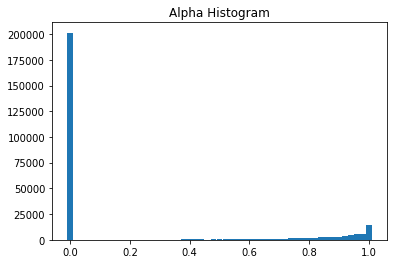

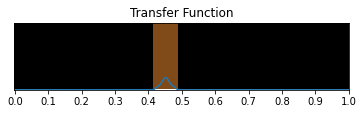

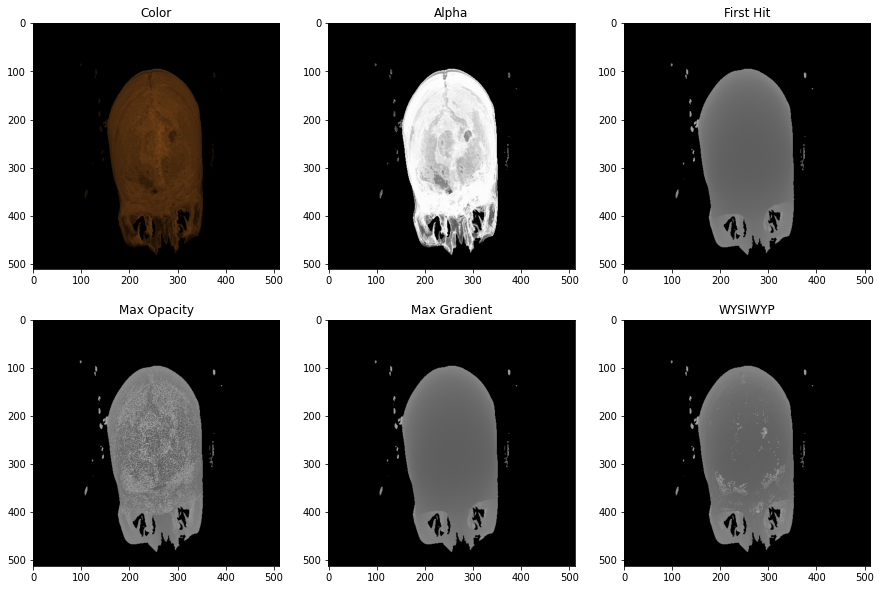

In [11]:
lf = in_circles(4.7)
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
x = torch.linspace(0.0, 1.0, BINS)
hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0).cpu()
print(f'Percentage 0.02 < Alpha < 0.9:  {hst[1:-1].sum()/rgbad[3].numel():.1%}')
print(f'Percentage        Alpha > 0.98: {hst[-1]/rgbad[3].numel():.1%}')
print(f'Percentage visible (>=0.02):    {1.0 - hst[0]/rgbad[3].numel():.1%}')
plt.bar(x, hst, width=1/BINS)
plt.title('Alpha Histogram')
plt.show()
plot_tf(tf, title='Transfer Function')
show_im(rgbad)

In [ ]:
!ls /

In [ ]:
raycaster = None
skips = 0
visibilities = []
for v in trange(N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, 
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = tex_from_pts(tfgen.generate()).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
            hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0)
            vis = hst[1:-1].sum()/rgbad[3].numel() # Visibility as in % of pixels with 0.02 < a < 0.9
            if (rgbad[3] > 0.0).float().mean() < 0.1 and (rgbad[4] > 0.0).float().mean() < 0.1:
                skips += 1
                print(f'Skipping another useless render ({skips})')
                continue
            else:
                visibilities.append(vis.cpu().float())
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': rgbad[:4].cpu().half(),
                    'wysiwyp1': rgbad[[4]].cpu().half(),
                    'wysiwyp2': rgbad[[5]].cpu().half(),
                    'wysiwyp3': rgbad[[6]].cpu().half(),
                    'alpha1': rgbad[[7]].cpu().half(),
                    'alpha2': rgbad[[8]].cpu().half(),
                    'alpha3': rgbad[[9]].cpu().half(),
                    'visibility': vis.cpu().float()
                }, out_dir/f'{nam}_{i}.pt')
                break
print(f'Average visibility in the dataset: {torch.stack(visibilitieslities).mean():.1%}')

  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another useless render (1)
Skipping another useless render (2)
Skipping another useless render (3)
Skipping another useless render (4)
Skipping another useless render (5)
Skipping another useless render (6)
Skipping another useless render (7)
Skipping another useless render (8)
Skipping another useless render (9)
Skipping another useless render (10)



  0%|          | 1/253 [00:12<53:06, 12.65s/it]

Skipping another useless render (11)
Skipping another useless render (12)
Skipping another useless render (13)
Skipping another useless render (14)
Skipping another useless render (15)
Skipping another useless render (16)



  1%|          | 2/253 [00:17<34:17,  8.20s/it]

Skipping another useless render (17)



  1%|          | 3/253 [00:19<21:46,  5.23s/it]

Skipping another useless render (18)
Skipping another useless render (19)
Skipping another useless render (20)
Skipping another useless render (21)
Skipping another useless render (22)



  2%|▏         | 4/253 [00:23<20:27,  4.93s/it]

Skipping another useless render (23)
Skipping another useless render (24)
Skipping another useless render (25)
Skipping another useless render (26)
Skipping another useless render (27)



  2%|▏         | 6/253 [00:29<14:04,  3.42s/it]

Skipping another useless render (28)
Skipping another useless render (29)
Skipping another useless render (30)
Skipping another useless render (31)
Skipping another useless render (32)
Skipping another useless render (33)
Skipping another useless render (34)
Skipping another useless render (35)
Skipping another useless render (36)
Skipping another useless render (37)
Skipping another useless render (38)
Skipping another useless render (39)
Skipping another useless render (40)
Skipping another useless render (41)
Skipping another useless render (42)
Skipping another useless render (43)
Skipping another useless render (44)
Skipping another useless render (45)
Skipping another useless render (46)
Skipping another useless render (47)
Skipping another useless render (48)
Skipping another useless render (49)
Skipping another useless render (50)
Skipping another useless render (51)
Skipping another useless render (52)
Skipping another useless render (53)
Skipping another useless render (54)
S


  3%|▎         | 7/253 [01:02<54:32, 13.30s/it]

Skipping another useless render (72)
Skipping another useless render (73)
Skipping another useless render (74)
Skipping another useless render (75)
Skipping another useless render (76)
Skipping another useless render (77)
Skipping another useless render (78)
Skipping another useless render (79)
Skipping another useless render (80)
Skipping another useless render (81)
Skipping another useless render (82)
Skipping another useless render (83)



  3%|▎         | 8/253 [01:12<49:12, 12.05s/it]

Skipping another useless render (84)
Skipping another useless render (85)
Skipping another useless render (86)
Skipping another useless render (87)
Skipping another useless render (88)
Skipping another useless render (89)
Skipping another useless render (90)
Skipping another useless render (91)
Skipping another useless render (92)
Skipping another useless render (93)



  4%|▎         | 9/253 [01:20<44:05, 10.84s/it]

Skipping another useless render (94)
Skipping another useless render (95)
Skipping another useless render (96)
Skipping another useless render (97)
Skipping another useless render (98)
Skipping another useless render (99)
Skipping another useless render (100)
Skipping another useless render (101)
Skipping another useless render (102)
Skipping another useless render (103)
Skipping another useless render (104)
Skipping another useless render (105)
Skipping another useless render (106)
Skipping another useless render (107)
Skipping another useless render (108)
Skipping another useless render (109)
Skipping another useless render (110)



  4%|▍         | 10/253 [01:33<46:53, 11.58s/it]

Skipping another useless render (111)
Skipping another useless render (112)



  4%|▍         | 11/253 [01:36<35:41,  8.85s/it]

Skipping another useless render (113)
Skipping another useless render (114)
Skipping another useless render (115)
Skipping another useless render (116)
Skipping another useless render (117)
Skipping another useless render (118)
Skipping another useless render (119)
Skipping another useless render (120)
Skipping another useless render (121)
Skipping another useless render (122)
Skipping another useless render (123)
Skipping another useless render (124)
Skipping another useless render (125)
Skipping another useless render (126)
Skipping another useless render (127)
Skipping another useless render (128)
Skipping another useless render (129)
Skipping another useless render (130)
Skipping another useless render (131)
Skipping another useless render (132)
Skipping another useless render (133)
Skipping another useless render (134)
Skipping another useless render (135)
Skipping another useless render (136)
Skipping another useless render (137)
Skipping another useless render (138)
Skipping ano


  5%|▍         | 12/253 [02:04<58:35, 14.59s/it]

Skipping another useless render (148)
Skipping another useless render (149)



  5%|▌         | 13/253 [02:06<43:19, 10.83s/it]

Skipping another useless render (150)
Skipping another useless render (151)
Skipping another useless render (152)
Skipping another useless render (153)
Skipping another useless render (154)
Skipping another useless render (155)
Skipping another useless render (156)
Skipping another useless render (157)
Skipping another useless render (158)
Skipping another useless render (159)
Skipping another useless render (160)
Skipping another useless render (161)
Skipping another useless render (162)
Skipping another useless render (163)
Skipping another useless render (164)
Skipping another useless render (165)
Skipping another useless render (166)
Skipping another useless render (167)



  6%|▌         | 14/253 [02:20<47:50, 12.01s/it]

Skipping another useless render (168)
Skipping another useless render (169)
Skipping another useless render (170)
Skipping another useless render (171)
Skipping another useless render (172)
Skipping another useless render (173)
Skipping another useless render (174)
Skipping another useless render (175)
Skipping another useless render (176)
Skipping another useless render (177)
Skipping another useless render (178)
Skipping another useless render (179)
Skipping another useless render (180)
Skipping another useless render (181)
Skipping another useless render (182)
Skipping another useless render (183)



  6%|▌         | 15/253 [02:34<48:54, 12.33s/it]

Skipping another useless render (184)
Skipping another useless render (185)
Skipping another useless render (186)
Skipping another useless render (187)
Skipping another useless render (188)
Skipping another useless render (189)
Skipping another useless render (190)
Skipping another useless render (191)
Skipping another useless render (192)
Skipping another useless render (193)
Skipping another useless render (194)
Skipping another useless render (195)
Skipping another useless render (196)
Skipping another useless render (197)
Skipping another useless render (198)
Skipping another useless render (199)
Skipping another useless render (200)
Skipping another useless render (201)
Skipping another useless render (202)
Skipping another useless render (203)



  6%|▋         | 16/253 [02:50<53:28, 13.54s/it]

Skipping another useless render (204)
Skipping another useless render (205)
Skipping another useless render (206)
Skipping another useless render (207)
Skipping another useless render (208)



  7%|▋         | 17/253 [02:55<43:10, 10.98s/it]

Skipping another useless render (209)
Skipping another useless render (210)



  7%|▋         | 18/253 [02:57<33:04,  8.45s/it]

Skipping another useless render (211)
Skipping another useless render (212)
Skipping another useless render (213)
Skipping another useless render (214)
Skipping another useless render (215)
Skipping another useless render (216)
Skipping another useless render (217)
Skipping another useless render (218)
Skipping another useless render (219)
Skipping another useless render (220)
Skipping another useless render (221)
Skipping another useless render (222)
Skipping another useless render (223)
Skipping another useless render (224)
Skipping another useless render (225)
Skipping another useless render (226)
Skipping another useless render (227)
Skipping another useless render (228)
Skipping another useless render (229)
Skipping another useless render (230)
Skipping another useless render (231)
Skipping another useless render (232)



  8%|▊         | 19/253 [03:15<43:05, 11.05s/it]

Skipping another useless render (233)
Skipping another useless render (234)
Skipping another useless render (235)
Skipping another useless render (236)
Skipping another useless render (237)
Skipping another useless render (238)
Skipping another useless render (239)
Skipping another useless render (240)
Skipping another useless render (241)
Skipping another useless render (242)
Skipping another useless render (243)
Skipping another useless render (244)
Skipping another useless render (245)
Skipping another useless render (246)
Skipping another useless render (247)
Skipping another useless render (248)
Skipping another useless render (249)
Skipping another useless render (250)
Skipping another useless render (251)
Skipping another useless render (252)
Skipping another useless render (253)
Skipping another useless render (254)
Skipping another useless render (255)
Skipping another useless render (256)
Skipping another useless render (257)
Skipping another useless render (258)
Skipping ano


  8%|▊         | 21/253 [03:50<50:02, 12.94s/it]  

Skipping another useless render (278)
Skipping another useless render (279)
Skipping another useless render (280)
Skipping another useless render (281)
Skipping another useless render (282)
Skipping another useless render (283)
Skipping another useless render (284)
Skipping another useless render (285)
Skipping another useless render (286)
Skipping another useless render (287)



  9%|▊         | 22/253 [03:58<44:04, 11.45s/it]

Skipping another useless render (288)
Skipping another useless render (289)
Skipping another useless render (290)
Skipping another useless render (291)
Skipping another useless render (292)
Skipping another useless render (293)
Skipping another useless render (294)



  9%|▉         | 24/253 [04:05<26:52,  7.04s/it]

Skipping another useless render (295)
Skipping another useless render (296)



 10%|▉         | 25/253 [04:07<21:39,  5.70s/it]

Skipping another useless render (297)
Skipping another useless render (298)
Skipping another useless render (299)
Skipping another useless render (300)
Skipping another useless render (301)
Skipping another useless render (302)
Skipping another useless render (303)
Skipping another useless render (304)
Skipping another useless render (305)
Skipping another useless render (306)
Skipping another useless render (307)
Skipping another useless render (308)
Skipping another useless render (309)
Skipping another useless render (310)
Skipping another useless render (311)
Skipping another useless render (312)
Skipping another useless render (313)



 10%|█         | 26/253 [04:21<30:55,  8.17s/it]

Skipping another useless render (314)



 11%|█         | 27/253 [04:23<23:13,  6.16s/it]

Skipping another useless render (315)
Skipping another useless render (316)
Skipping another useless render (317)
Skipping another useless render (318)
Skipping another useless render (319)
Skipping another useless render (320)
Skipping another useless render (321)
Skipping another useless render (322)



 11%|█         | 28/253 [04:29<23:59,  6.40s/it]

Skipping another useless render (323)
Skipping another useless render (324)
Skipping another useless render (325)
Skipping another useless render (326)
Skipping another useless render (327)
Skipping another useless render (328)
Skipping another useless render (329)
Skipping another useless render (330)
Skipping another useless render (331)
Skipping another useless render (332)
Skipping another useless render (333)
Skipping another useless render (334)
Skipping another useless render (335)
Skipping another useless render (336)
Skipping another useless render (337)
Skipping another useless render (338)
Skipping another useless render (339)
Skipping another useless render (340)
Skipping another useless render (341)
Skipping another useless render (342)
Skipping another useless render (343)
Skipping another useless render (344)
Skipping another useless render (345)
Skipping another useless render (346)
Skipping another useless render (347)
Skipping another useless render (348)
Skipping ano


 11%|█▏        | 29/253 [04:59<49:36, 13.29s/it]

Skipping another useless render (361)
Skipping another useless render (362)
Skipping another useless render (363)
Skipping another useless render (364)
Skipping another useless render (365)
Skipping another useless render (366)
Skipping another useless render (367)
Skipping another useless render (368)
Skipping another useless render (369)
Skipping another useless render (370)
Skipping another useless render (371)
Skipping another useless render (372)
Skipping another useless render (373)
Skipping another useless render (374)
Skipping another useless render (375)
Skipping another useless render (376)
Skipping another useless render (377)
Skipping another useless render (378)
Skipping another useless render (379)
Skipping another useless render (380)
Skipping another useless render (381)
Skipping another useless render (382)
Skipping another useless render (383)
Skipping another useless render (384)
Skipping another useless render (385)
Skipping another useless render (386)
Skipping ano


 12%|█▏        | 31/253 [05:23<43:02, 11.63s/it]  

Skipping another useless render (391)
Skipping another useless render (392)
Skipping another useless render (393)
Skipping another useless render (394)
Skipping another useless render (395)
Skipping another useless render (396)
Skipping another useless render (397)
Skipping another useless render (398)
Skipping another useless render (399)
Skipping another useless render (400)
Skipping another useless render (401)
Skipping another useless render (402)
Skipping another useless render (403)
Skipping another useless render (404)
Skipping another useless render (405)
Skipping another useless render (406)
Skipping another useless render (407)
Skipping another useless render (408)
Skipping another useless render (409)



 13%|█▎        | 32/253 [05:38<47:00, 12.76s/it]

Skipping another useless render (410)
Skipping another useless render (411)
Skipping another useless render (412)
Skipping another useless render (413)



 13%|█▎        | 33/253 [05:42<36:58, 10.08s/it]

Skipping another useless render (414)
Skipping another useless render (415)
Skipping another useless render (416)
Skipping another useless render (417)



 13%|█▎        | 34/253 [05:46<29:41,  8.14s/it]

Skipping another useless render (418)
Skipping another useless render (419)
Skipping another useless render (420)
Skipping another useless render (421)
Skipping another useless render (422)
Skipping another useless render (423)
Skipping another useless render (424)
Skipping another useless render (425)
Skipping another useless render (426)
Skipping another useless render (427)
Skipping another useless render (428)
Skipping another useless render (429)
Skipping another useless render (430)
Skipping another useless render (431)
Skipping another useless render (432)
Skipping another useless render (433)
Skipping another useless render (434)
Skipping another useless render (435)
Skipping another useless render (436)
Skipping another useless render (437)
Skipping another useless render (438)
Skipping another useless render (439)
Skipping another useless render (440)
Skipping another useless render (441)
Skipping another useless render (442)
Skipping another useless render (443)
Skipping ano


 14%|█▍        | 35/253 [06:17<55:13, 15.20s/it]

Skipping another useless render (458)
Skipping another useless render (459)
Skipping another useless render (460)
Skipping another useless render (461)
Skipping another useless render (462)
Skipping another useless render (463)
Skipping another useless render (464)
Skipping another useless render (465)
Skipping another useless render (466)
Skipping another useless render (467)
Skipping another useless render (468)



 14%|█▍        | 36/253 [06:26<48:11, 13.32s/it]

Skipping another useless render (469)
Skipping another useless render (470)
Skipping another useless render (471)
Skipping another useless render (472)
Skipping another useless render (473)
Skipping another useless render (474)
Skipping another useless render (475)
Skipping another useless render (476)
Skipping another useless render (477)
Skipping another useless render (478)



 15%|█▍        | 37/253 [06:35<42:46, 11.88s/it]

Skipping another useless render (479)
Skipping another useless render (480)
Skipping another useless render (481)
Skipping another useless render (482)
Skipping another useless render (483)
Skipping another useless render (484)
Skipping another useless render (485)
Skipping another useless render (486)
Skipping another useless render (487)
Skipping another useless render (488)
Skipping another useless render (489)
Skipping another useless render (490)
Skipping another useless render (491)
Skipping another useless render (492)
Skipping another useless render (493)
Skipping another useless render (494)
Skipping another useless render (495)
Skipping another useless render (496)



 15%|█▌        | 38/253 [06:49<45:23, 12.67s/it]

Skipping another useless render (497)
Skipping another useless render (498)
Skipping another useless render (499)
Skipping another useless render (500)
Skipping another useless render (501)
Skipping another useless render (502)



 15%|█▌        | 39/253 [06:55<37:29, 10.51s/it]

Skipping another useless render (503)
Skipping another useless render (504)



 16%|█▌        | 40/253 [06:57<28:30,  8.03s/it]

Skipping another useless render (505)
Skipping another useless render (506)
Skipping another useless render (507)
Skipping another useless render (508)
Skipping another useless render (509)
Skipping another useless render (510)
Skipping another useless render (511)



 17%|█▋        | 42/253 [07:04<18:59,  5.40s/it]

Skipping another useless render (512)
Skipping another useless render (513)
Skipping another useless render (514)
Skipping another useless render (515)
Skipping another useless render (516)
Skipping another useless render (517)
Skipping another useless render (518)
Skipping another useless render (519)
Skipping another useless render (520)
Skipping another useless render (521)
Skipping another useless render (522)
Skipping another useless render (523)



 17%|█▋        | 43/253 [07:13<23:07,  6.61s/it]

Skipping another useless render (524)
Skipping another useless render (525)
Skipping another useless render (526)
Skipping another useless render (527)
Skipping another useless render (528)
Skipping another useless render (529)
Skipping another useless render (530)
Skipping another useless render (531)
Skipping another useless render (532)
Skipping another useless render (533)
Skipping another useless render (534)
Skipping another useless render (535)
Skipping another useless render (536)
Skipping another useless render (537)
Skipping another useless render (538)
Skipping another useless render (539)
Skipping another useless render (540)
Skipping another useless render (541)
Skipping another useless render (542)
Skipping another useless render (543)
Skipping another useless render (544)
Skipping another useless render (545)
Skipping another useless render (546)
Skipping another useless render (547)
Skipping another useless render (548)
Skipping another useless render (549)
Skipping ano


 17%|█▋        | 44/253 [07:37<41:06, 11.80s/it]

Skipping another useless render (555)
Skipping another useless render (556)
Skipping another useless render (557)



 18%|█▊        | 46/253 [07:41<23:14,  6.74s/it]

Skipping another useless render (558)
Skipping another useless render (559)
Skipping another useless render (560)
Skipping another useless render (561)
Skipping another useless render (562)
Skipping another useless render (563)
Skipping another useless render (564)
Skipping another useless render (565)
Skipping another useless render (566)
Skipping another useless render (567)
Skipping another useless render (568)
Skipping another useless render (569)
Skipping another useless render (570)
Skipping another useless render (571)
Skipping another useless render (572)
Skipping another useless render (573)
Skipping another useless render (574)
Skipping another useless render (575)
Skipping another useless render (576)
Skipping another useless render (577)
Skipping another useless render (578)
Skipping another useless render (579)
Skipping another useless render (580)
Skipping another useless render (581)
Skipping another useless render (582)
Skipping another useless render (583)
Skipping ano


 19%|█▊        | 47/253 [08:10<45:44, 13.32s/it]

Skipping another useless render (596)



 19%|█▉        | 48/253 [08:12<33:38,  9.85s/it]

Skipping another useless render (597)
Skipping another useless render (598)
Skipping another useless render (599)
Skipping another useless render (600)
Skipping another useless render (601)
Skipping another useless render (602)
Skipping another useless render (603)
Skipping another useless render (604)
Skipping another useless render (605)
Skipping another useless render (606)
Skipping another useless render (607)
Skipping another useless render (608)
Skipping another useless render (609)
Skipping another useless render (610)
Skipping another useless render (611)
Skipping another useless render (612)
Skipping another useless render (613)
Skipping another useless render (614)
Skipping another useless render (615)
Skipping another useless render (616)
Skipping another useless render (617)
Skipping another useless render (618)
Skipping another useless render (619)
Skipping another useless render (620)
Skipping another useless render (621)
Skipping another useless render (622)
Skipping ano


 19%|█▉        | 49/253 [08:37<49:13, 14.48s/it]

Skipping another useless render (629)
Skipping another useless render (630)
Skipping another useless render (631)
Skipping another useless render (632)



 20%|█▉        | 50/253 [08:40<37:51, 11.19s/it]

Skipping another useless render (633)
Skipping another useless render (634)
Skipping another useless render (635)
Skipping another useless render (636)
Skipping another useless render (637)
Skipping another useless render (638)
Skipping another useless render (639)
Skipping another useless render (640)



 20%|██        | 51/253 [08:47<33:06,  9.84s/it]

Skipping another useless render (641)
Skipping another useless render (642)
Skipping another useless render (643)
Skipping another useless render (644)
Skipping another useless render (645)
Skipping another useless render (646)
Skipping another useless render (647)
Skipping another useless render (648)
Skipping another useless render (649)
Skipping another useless render (650)
Skipping another useless render (651)



 21%|██        | 52/253 [08:56<32:25,  9.68s/it]

Skipping another useless render (652)



 21%|██        | 53/253 [08:58<24:19,  7.30s/it]

Skipping another useless render (653)
Skipping another useless render (654)
Skipping another useless render (655)
Skipping another useless render (656)
Skipping another useless render (657)
Skipping another useless render (658)
Skipping another useless render (659)
Skipping another useless render (660)
Skipping another useless render (661)
Skipping another useless render (662)



 21%|██▏       | 54/253 [09:07<25:21,  7.64s/it]

Skipping another useless render (663)
Skipping another useless render (664)
Skipping another useless render (665)
Skipping another useless render (666)
Skipping another useless render (667)
Skipping another useless render (668)
Skipping another useless render (669)
Skipping another useless render (670)
Skipping another useless render (671)
Skipping another useless render (672)
Skipping another useless render (673)
Skipping another useless render (674)
Skipping another useless render (675)
Skipping another useless render (676)
Skipping another useless render (677)
Skipping another useless render (678)
Skipping another useless render (679)
Skipping another useless render (680)
Skipping another useless render (681)
Skipping another useless render (682)
Skipping another useless render (683)
Skipping another useless render (684)
Skipping another useless render (685)
Skipping another useless render (686)
Skipping another useless render (687)
Skipping another useless render (688)
Skipping ano


 22%|██▏       | 55/253 [09:41<51:20, 15.56s/it]

Skipping another useless render (706)
Skipping another useless render (707)
Skipping another useless render (708)
Skipping another useless render (709)
Skipping another useless render (710)
Skipping another useless render (711)
Skipping another useless render (712)
Skipping another useless render (713)



 22%|██▏       | 56/253 [09:47<42:25, 12.92s/it]

Skipping another useless render (714)
Skipping another useless render (715)



 23%|██▎       | 57/253 [09:50<31:43,  9.71s/it]

Skipping another useless render (716)
Skipping another useless render (717)
Skipping another useless render (718)



 23%|██▎       | 58/253 [09:53<25:13,  7.76s/it]

Skipping another useless render (719)
Skipping another useless render (720)
Skipping another useless render (721)
Skipping another useless render (722)
Skipping another useless render (723)
Skipping another useless render (724)
Skipping another useless render (725)
Skipping another useless render (726)



 24%|██▎       | 60/253 [10:01<18:07,  5.64s/it]

Skipping another useless render (727)
Skipping another useless render (728)
Skipping another useless render (729)
Skipping another useless render (730)



 24%|██▍       | 61/253 [10:05<16:37,  5.20s/it]

Skipping another useless render (731)
Skipping another useless render (732)
Skipping another useless render (733)
Skipping another useless render (734)
Skipping another useless render (735)
Skipping another useless render (736)
Skipping another useless render (737)
Skipping another useless render (738)
Skipping another useless render (739)
Skipping another useless render (740)



 25%|██▍       | 62/253 [10:14<19:23,  6.09s/it]

Skipping another useless render (741)
Skipping another useless render (742)
Skipping another useless render (743)
Skipping another useless render (744)
Skipping another useless render (745)
Skipping another useless render (746)
Skipping another useless render (747)



 25%|██▍       | 63/253 [10:20<19:16,  6.09s/it]

Skipping another useless render (748)
Skipping another useless render (749)
Skipping another useless render (750)
Skipping another useless render (751)
Skipping another useless render (752)
Skipping another useless render (753)
Skipping another useless render (754)
Skipping another useless render (755)
Skipping another useless render (756)
Skipping another useless render (757)
Skipping another useless render (758)
Skipping another useless render (759)
Skipping another useless render (760)
Skipping another useless render (761)
Skipping another useless render (762)
Skipping another useless render (763)
Skipping another useless render (764)
Skipping another useless render (765)
Skipping another useless render (766)
Skipping another useless render (767)
Skipping another useless render (768)
Skipping another useless render (769)
Skipping another useless render (770)
Skipping another useless render (771)
Skipping another useless render (772)
Skipping another useless render (773)
Skipping ano


 25%|██▌       | 64/253 [10:43<35:42, 11.34s/it]

Skipping another useless render (778)
Skipping another useless render (779)
Skipping another useless render (780)
Skipping another useless render (781)
Skipping another useless render (782)
Skipping another useless render (783)
Skipping another useless render (784)
Skipping another useless render (785)
Skipping another useless render (786)
Skipping another useless render (787)
Skipping another useless render (788)
Skipping another useless render (789)
Skipping another useless render (790)
Skipping another useless render (791)
Skipping another useless render (792)
Skipping another useless render (793)
Skipping another useless render (794)
Skipping another useless render (795)
Skipping another useless render (796)
Skipping another useless render (797)
Skipping another useless render (798)
Skipping another useless render (799)
Skipping another useless render (800)
Skipping another useless render (801)
Skipping another useless render (802)
Skipping another useless render (803)



 26%|██▌       | 65/253 [11:03<43:31, 13.89s/it]

Skipping another useless render (804)
Skipping another useless render (805)
Skipping another useless render (806)
Skipping another useless render (807)
Skipping another useless render (808)
Skipping another useless render (809)
Skipping another useless render (810)
Skipping another useless render (811)
Skipping another useless render (812)
Skipping another useless render (813)
Skipping another useless render (814)
Skipping another useless render (815)
Skipping another useless render (816)
Skipping another useless render (817)
Skipping another useless render (818)
Skipping another useless render (819)
Skipping another useless render (820)
Skipping another useless render (821)
Skipping another useless render (822)
Skipping another useless render (823)
Skipping another useless render (824)
Skipping another useless render (825)
Skipping another useless render (826)
Skipping another useless render (827)
Skipping another useless render (828)
Skipping another useless render (829)
Skipping ano


 26%|██▌       | 66/253 [11:55<1:19:01, 25.35s/it]

Skipping another useless render (871)
Skipping another useless render (872)



 26%|██▋       | 67/253 [11:57<56:48, 18.33s/it]  

Skipping another useless render (873)
Skipping another useless render (874)
Skipping another useless render (875)
Skipping another useless render (876)
Skipping another useless render (877)
Skipping another useless render (878)
Skipping another useless render (879)
Skipping another useless render (880)
Skipping another useless render (881)
Skipping another useless render (882)
Skipping another useless render (883)
Skipping another useless render (884)
Skipping another useless render (885)
Skipping another useless render (886)



 27%|██▋       | 68/253 [12:09<50:39, 16.43s/it]

Skipping another useless render (887)
Skipping another useless render (888)
Skipping another useless render (889)
Skipping another useless render (890)
Skipping another useless render (891)
Skipping another useless render (892)
Skipping another useless render (893)
Skipping another useless render (894)
Skipping another useless render (895)
Skipping another useless render (896)
Skipping another useless render (897)
Skipping another useless render (898)
Skipping another useless render (899)
Skipping another useless render (900)
Skipping another useless render (901)
Skipping another useless render (902)
Skipping another useless render (903)
Skipping another useless render (904)
Skipping another useless render (905)
Skipping another useless render (906)
Skipping another useless render (907)
Skipping another useless render (908)
Skipping another useless render (909)
Skipping another useless render (910)
Skipping another useless render (911)



 27%|██▋       | 69/253 [12:29<53:14, 17.36s/it]

Skipping another useless render (912)
Skipping another useless render (913)
Skipping another useless render (914)
Skipping another useless render (915)
Skipping another useless render (916)
Skipping another useless render (917)
Skipping another useless render (918)
Skipping another useless render (919)
Skipping another useless render (920)
Skipping another useless render (921)
Skipping another useless render (922)
Skipping another useless render (923)
Skipping another useless render (924)
Skipping another useless render (925)
Skipping another useless render (926)
Skipping another useless render (927)
Skipping another useless render (928)
Skipping another useless render (929)
Skipping another useless render (930)
Skipping another useless render (931)



 28%|██▊       | 70/253 [12:45<52:13, 17.12s/it]

Skipping another useless render (932)
Skipping another useless render (933)



 29%|██▉       | 73/253 [12:49<19:48,  6.60s/it]

Skipping another useless render (934)
Skipping another useless render (935)
Skipping another useless render (936)
Skipping another useless render (937)
Skipping another useless render (938)
Skipping another useless render (939)
Skipping another useless render (940)
Skipping another useless render (941)
Skipping another useless render (942)
Skipping another useless render (943)
Skipping another useless render (944)
Skipping another useless render (945)
Skipping another useless render (946)
Skipping another useless render (947)
Skipping another useless render (948)
Skipping another useless render (949)
Skipping another useless render (950)
Skipping another useless render (951)
Skipping another useless render (952)
Skipping another useless render (953)
Skipping another useless render (954)
Skipping another useless render (955)
Skipping another useless render (956)
Skipping another useless render (957)
Skipping another useless render (958)
Skipping another useless render (959)
Skipping ano


 29%|██▉       | 74/253 [14:04<1:20:41, 27.05s/it]

Skipping another useless render (1032)
Skipping another useless render (1033)
Skipping another useless render (1034)
Skipping another useless render (1035)
Skipping another useless render (1036)
Skipping another useless render (1037)
Skipping another useless render (1038)
Skipping another useless render (1039)
Skipping another useless render (1040)
Skipping another useless render (1041)
Skipping another useless render (1042)
Skipping another useless render (1043)
Skipping another useless render (1044)
Skipping another useless render (1045)
Skipping another useless render (1046)
Skipping another useless render (1047)
Skipping another useless render (1048)
Skipping another useless render (1049)
Skipping another useless render (1050)
Skipping another useless render (1051)
Skipping another useless render (1052)
Skipping another useless render (1053)
Skipping another useless render (1054)
Skipping another useless render (1055)
Skipping another useless render (1056)



 30%|██▉       | 75/253 [14:25<1:14:44, 25.20s/it]

Skipping another useless render (1057)
Skipping another useless render (1058)
Skipping another useless render (1059)
Skipping another useless render (1060)
Skipping another useless render (1061)
Skipping another useless render (1062)
Skipping another useless render (1063)
Skipping another useless render (1064)
Skipping another useless render (1065)
Skipping another useless render (1066)
Skipping another useless render (1067)
Skipping another useless render (1068)
Skipping another useless render (1069)
Skipping another useless render (1070)
Skipping another useless render (1071)
Skipping another useless render (1072)
Skipping another useless render (1073)
Skipping another useless render (1074)
Skipping another useless render (1075)
Skipping another useless render (1076)
Skipping another useless render (1077)
Skipping another useless render (1078)
Skipping another useless render (1079)
Skipping another useless render (1080)
Skipping another useless render (1081)
Skipping another useless 


 30%|███       | 76/253 [14:48<1:12:09, 24.46s/it]

Skipping another useless render (1085)
Skipping another useless render (1086)
Skipping another useless render (1087)
Skipping another useless render (1088)
Skipping another useless render (1089)
Skipping another useless render (1090)
Skipping another useless render (1091)



 30%|███       | 77/253 [14:53<55:26, 18.90s/it]  

Skipping another useless render (1092)



 31%|███       | 78/253 [14:55<39:56, 13.69s/it]

Skipping another useless render (1093)
Skipping another useless render (1094)
Skipping another useless render (1095)
Skipping another useless render (1096)
Skipping another useless render (1097)
Skipping another useless render (1098)
Skipping another useless render (1099)
Skipping another useless render (1100)
Skipping another useless render (1101)
Skipping another useless render (1102)



 31%|███       | 79/253 [15:03<34:26, 11.88s/it]

Skipping another useless render (1103)
Skipping another useless render (1104)
Skipping another useless render (1105)
Skipping another useless render (1106)
Skipping another useless render (1107)
Skipping another useless render (1108)
Skipping another useless render (1109)
Skipping another useless render (1110)
Skipping another useless render (1111)
Skipping another useless render (1112)
Skipping another useless render (1113)
Skipping another useless render (1114)



 32%|███▏      | 80/253 [15:13<32:47, 11.37s/it]

Skipping another useless render (1115)
Skipping another useless render (1116)
Skipping another useless render (1117)
Skipping another useless render (1118)



 32%|███▏      | 81/253 [15:17<26:04,  9.10s/it]

Skipping another useless render (1119)
Skipping another useless render (1120)
Skipping another useless render (1121)
Skipping another useless render (1122)
Skipping another useless render (1123)
Skipping another useless render (1124)
Skipping another useless render (1125)
Skipping another useless render (1126)
Skipping another useless render (1127)
Skipping another useless render (1128)
Skipping another useless render (1129)
Skipping another useless render (1130)
Skipping another useless render (1131)
Skipping another useless render (1132)
Skipping another useless render (1133)
Skipping another useless render (1134)
Skipping another useless render (1135)
Skipping another useless render (1136)
Skipping another useless render (1137)



 32%|███▏      | 82/253 [15:33<32:08, 11.28s/it]

Skipping another useless render (1138)
Skipping another useless render (1139)
Skipping another useless render (1140)
Skipping another useless render (1141)
Skipping another useless render (1142)
Skipping another useless render (1143)
Skipping another useless render (1144)
Skipping another useless render (1145)
Skipping another useless render (1146)
Skipping another useless render (1147)



 33%|███▎      | 83/253 [15:41<29:20, 10.35s/it]

Skipping another useless render (1148)
Skipping another useless render (1149)
Skipping another useless render (1150)
Skipping another useless render (1151)



 33%|███▎      | 84/253 [15:45<23:40,  8.41s/it]

Skipping another useless render (1152)
Skipping another useless render (1153)
Skipping another useless render (1154)



 34%|███▎      | 85/253 [15:48<19:06,  6.83s/it]

Skipping another useless render (1155)
Skipping another useless render (1156)
Skipping another useless render (1157)
Skipping another useless render (1158)
Skipping another useless render (1159)
Skipping another useless render (1160)
Skipping another useless render (1161)
Skipping another useless render (1162)
Skipping another useless render (1163)
Skipping another useless render (1164)
Skipping another useless render (1165)
Skipping another useless render (1166)
Skipping another useless render (1167)
Skipping another useless render (1168)
Skipping another useless render (1169)
Skipping another useless render (1170)
Skipping another useless render (1171)
Skipping another useless render (1172)
Skipping another useless render (1173)
Skipping another useless render (1174)
Skipping another useless render (1175)
Skipping another useless render (1176)
Skipping another useless render (1177)
Skipping another useless render (1178)
Skipping another useless render (1179)
Skipping another useless 


 34%|███▍      | 86/253 [16:10<31:39, 11.38s/it]

Skipping another useless render (1183)
Skipping another useless render (1184)
Skipping another useless render (1185)
Skipping another useless render (1186)
Skipping another useless render (1187)
Skipping another useless render (1188)
Skipping another useless render (1189)



 34%|███▍      | 87/253 [16:16<27:05,  9.79s/it]

Skipping another useless render (1190)
Skipping another useless render (1191)
Skipping another useless render (1192)
Skipping another useless render (1193)
Skipping another useless render (1194)
Skipping another useless render (1195)
Skipping another useless render (1196)
Skipping another useless render (1197)
Skipping another useless render (1198)
Skipping another useless render (1199)
Skipping another useless render (1200)
Skipping another useless render (1201)
Skipping another useless render (1202)



 35%|███▌      | 89/253 [16:28<19:56,  7.30s/it]

Skipping another useless render (1203)
Skipping another useless render (1204)
Skipping another useless render (1205)
Skipping another useless render (1206)
Skipping another useless render (1207)



 36%|███▌      | 90/253 [16:32<17:37,  6.49s/it]

Skipping another useless render (1208)
Skipping another useless render (1209)
Skipping another useless render (1210)
Skipping another useless render (1211)
Skipping another useless render (1212)
Skipping another useless render (1213)
Skipping another useless render (1214)
Skipping another useless render (1215)
Skipping another useless render (1216)
Skipping another useless render (1217)
Skipping another useless render (1218)
Skipping another useless render (1219)
Skipping another useless render (1220)
Skipping another useless render (1221)
Skipping another useless render (1222)
Skipping another useless render (1223)
Skipping another useless render (1224)
Skipping another useless render (1225)
Skipping another useless render (1226)
Skipping another useless render (1227)
Skipping another useless render (1228)
Skipping another useless render (1229)
Skipping another useless render (1230)
Skipping another useless render (1231)
Skipping another useless render (1232)
Skipping another useless 


 36%|███▌      | 91/253 [17:18<49:09, 18.21s/it]

Skipping another useless render (1268)



 36%|███▋      | 92/253 [17:20<35:30, 13.24s/it]

Skipping another useless render (1269)
Skipping another useless render (1270)
Skipping another useless render (1271)
Skipping another useless render (1272)
Skipping another useless render (1273)
Skipping another useless render (1274)
Skipping another useless render (1275)
Skipping another useless render (1276)
Skipping another useless render (1277)
Skipping another useless render (1278)
Skipping another useless render (1279)
Skipping another useless render (1280)
Skipping another useless render (1281)
Skipping another useless render (1282)
Skipping another useless render (1283)
Skipping another useless render (1284)
Skipping another useless render (1285)



 37%|███▋      | 93/253 [17:33<35:41, 13.39s/it]

Skipping another useless render (1286)
Skipping another useless render (1287)
Skipping another useless render (1288)
Skipping another useless render (1289)
Skipping another useless render (1290)
Skipping another useless render (1291)
Skipping another useless render (1292)
Skipping another useless render (1293)
Skipping another useless render (1294)
Skipping another useless render (1295)
Skipping another useless render (1296)
Skipping another useless render (1297)
Skipping another useless render (1298)
Skipping another useless render (1299)
Skipping another useless render (1300)
Skipping another useless render (1301)
Skipping another useless render (1302)
Skipping another useless render (1303)
Skipping another useless render (1304)
Skipping another useless render (1305)
Skipping another useless render (1306)
Skipping another useless render (1307)
Skipping another useless render (1308)
Skipping another useless render (1309)
Skipping another useless render (1310)
Skipping another useless 


 37%|███▋      | 94/253 [17:58<44:09, 16.66s/it]

Skipping another useless render (1316)
Skipping another useless render (1317)
Skipping another useless render (1318)
Skipping another useless render (1319)
Skipping another useless render (1320)
Skipping another useless render (1321)



 38%|███▊      | 95/253 [18:03<34:50, 13.23s/it]

Skipping another useless render (1322)
Skipping another useless render (1323)
Skipping another useless render (1324)
Skipping another useless render (1325)
Skipping another useless render (1326)
Skipping another useless render (1327)
Skipping another useless render (1328)
Skipping another useless render (1329)
Skipping another useless render (1330)
Skipping another useless render (1331)
Skipping another useless render (1332)
Skipping another useless render (1333)



 38%|███▊      | 97/253 [18:13<22:34,  8.68s/it]

Skipping another useless render (1334)
Skipping another useless render (1335)
Skipping another useless render (1336)
Skipping another useless render (1337)
Skipping another useless render (1338)
Skipping another useless render (1339)
Skipping another useless render (1340)
Skipping another useless render (1341)
Skipping another useless render (1342)
Skipping another useless render (1343)



 39%|███▊      | 98/253 [18:21<21:59,  8.51s/it]

Skipping another useless render (1344)



 40%|███▉      | 100/253 [18:23<12:00,  4.71s/it]

Skipping another useless render (1345)
Skipping another useless render (1346)
Skipping another useless render (1347)



 40%|███▉      | 101/253 [18:26<10:38,  4.20s/it]

Skipping another useless render (1348)
Skipping another useless render (1349)
Skipping another useless render (1350)
Skipping another useless render (1351)
Skipping another useless render (1352)
Skipping another useless render (1353)
Skipping another useless render (1354)
Skipping another useless render (1355)
Skipping another useless render (1356)
Skipping another useless render (1357)
Skipping another useless render (1358)



 41%|████      | 103/253 [18:37<10:54,  4.36s/it]

Skipping another useless render (1359)
Skipping another useless render (1360)
Skipping another useless render (1361)
Skipping another useless render (1362)
Skipping another useless render (1363)
Skipping another useless render (1364)
Skipping another useless render (1365)
Skipping another useless render (1366)
Skipping another useless render (1367)
Skipping another useless render (1368)
Skipping another useless render (1369)
Skipping another useless render (1370)
Skipping another useless render (1371)
Skipping another useless render (1372)
Skipping another useless render (1373)
Skipping another useless render (1374)
Skipping another useless render (1375)
Skipping another useless render (1376)
Skipping another useless render (1377)
Skipping another useless render (1378)



 41%|████      | 104/253 [18:54<20:07,  8.10s/it]

Skipping another useless render (1379)
Skipping another useless render (1380)
Skipping another useless render (1381)
Skipping another useless render (1382)
Skipping another useless render (1383)
Skipping another useless render (1384)
Skipping another useless render (1385)
Skipping another useless render (1386)
Skipping another useless render (1387)
Skipping another useless render (1388)
Skipping another useless render (1389)
Skipping another useless render (1390)
Skipping another useless render (1391)
Skipping another useless render (1392)



 42%|████▏     | 105/253 [19:06<22:56,  9.30s/it]

Skipping another useless render (1393)
Skipping another useless render (1394)
Skipping another useless render (1395)
Skipping another useless render (1396)
Skipping another useless render (1397)
Skipping another useless render (1398)
Skipping another useless render (1399)
Skipping another useless render (1400)
Skipping another useless render (1401)
Skipping another useless render (1402)
Skipping another useless render (1403)
Skipping another useless render (1404)



 42%|████▏     | 106/253 [19:16<23:08,  9.45s/it]

Skipping another useless render (1405)
Skipping another useless render (1406)
Skipping another useless render (1407)
Skipping another useless render (1408)
Skipping another useless render (1409)
Skipping another useless render (1410)
Skipping another useless render (1411)
Skipping another useless render (1412)



 42%|████▏     | 107/253 [19:23<21:05,  8.67s/it]

Skipping another useless render (1413)
Skipping another useless render (1414)
Skipping another useless render (1415)
Skipping another useless render (1416)
Skipping another useless render (1417)
Skipping another useless render (1418)
Skipping another useless render (1419)
Skipping another useless render (1420)
Skipping another useless render (1421)
Skipping another useless render (1422)
Skipping another useless render (1423)
Skipping another useless render (1424)
Skipping another useless render (1425)
Skipping another useless render (1426)
Skipping another useless render (1427)
Skipping another useless render (1428)
Skipping another useless render (1429)
Skipping another useless render (1430)
Skipping another useless render (1431)



 43%|████▎     | 108/253 [19:38<25:57, 10.74s/it]

Skipping another useless render (1432)
Skipping another useless render (1433)
Skipping another useless render (1434)
Skipping another useless render (1435)
Skipping another useless render (1436)
Skipping another useless render (1437)
Skipping another useless render (1438)
Skipping another useless render (1439)
Skipping another useless render (1440)
Skipping another useless render (1441)
Skipping another useless render (1442)
Skipping another useless render (1443)
Skipping another useless render (1444)
Skipping another useless render (1445)
Skipping another useless render (1446)



 43%|████▎     | 109/253 [19:51<27:08, 11.31s/it]

Skipping another useless render (1447)
Skipping another useless render (1448)
Skipping another useless render (1449)
Skipping another useless render (1450)
Skipping another useless render (1451)
Skipping another useless render (1452)
Skipping another useless render (1453)
Skipping another useless render (1454)
Skipping another useless render (1455)
Skipping another useless render (1456)
Skipping another useless render (1457)
Skipping another useless render (1458)
Skipping another useless render (1459)
Skipping another useless render (1460)
Skipping another useless render (1461)
Skipping another useless render (1462)
Skipping another useless render (1463)
Skipping another useless render (1464)
Skipping another useless render (1465)
Skipping another useless render (1466)
Skipping another useless render (1467)
Skipping another useless render (1468)
Skipping another useless render (1469)
Skipping another useless render (1470)
Skipping another useless render (1471)
Skipping another useless 


 43%|████▎     | 110/253 [20:12<33:56, 14.24s/it]

Skipping another useless render (1473)
Skipping another useless render (1474)
Skipping another useless render (1475)
Skipping another useless render (1476)
Skipping another useless render (1477)
Skipping another useless render (1478)
Skipping another useless render (1479)
Skipping another useless render (1480)
Skipping another useless render (1481)
Skipping another useless render (1482)
Skipping another useless render (1483)
Skipping another useless render (1484)
Skipping another useless render (1485)
Skipping another useless render (1486)
Skipping another useless render (1487)
Skipping another useless render (1488)
Skipping another useless render (1489)
Skipping another useless render (1490)
Skipping another useless render (1491)
Skipping another useless render (1492)
Skipping another useless render (1493)
Skipping another useless render (1494)
Skipping another useless render (1495)
Skipping another useless render (1496)
Skipping another useless render (1497)
Skipping another useless 


 44%|████▍     | 111/253 [20:33<38:46, 16.38s/it]

Skipping another useless render (1500)
Skipping another useless render (1501)
Skipping another useless render (1502)
Skipping another useless render (1503)
Skipping another useless render (1504)
Skipping another useless render (1505)
Skipping another useless render (1506)
Skipping another useless render (1507)
Skipping another useless render (1508)
Skipping another useless render (1509)



 44%|████▍     | 112/253 [20:43<33:30, 14.26s/it]

Skipping another useless render (1510)
Skipping another useless render (1511)
Skipping another useless render (1512)
Skipping another useless render (1513)
Skipping another useless render (1514)
Skipping another useless render (1515)
Skipping another useless render (1516)
Skipping another useless render (1517)
Skipping another useless render (1518)
Skipping another useless render (1519)
Skipping another useless render (1520)
Skipping another useless render (1521)
Skipping another useless render (1522)
Skipping another useless render (1523)
Skipping another useless render (1524)
Skipping another useless render (1525)
Skipping another useless render (1526)
Skipping another useless render (1527)
Skipping another useless render (1528)
Skipping another useless render (1529)
Skipping another useless render (1530)
Skipping another useless render (1531)
Skipping another useless render (1532)
Skipping another useless render (1533)
Skipping another useless render (1534)
Skipping another useless 


 45%|████▍     | 113/253 [21:10<42:24, 18.18s/it]

Skipping another useless render (1546)



 45%|████▌     | 114/253 [21:11<30:29, 13.16s/it]

Skipping another useless render (1547)
Skipping another useless render (1548)
Skipping another useless render (1549)



 45%|████▌     | 115/253 [21:15<23:17, 10.13s/it]

Skipping another useless render (1550)
Skipping another useless render (1551)
Skipping another useless render (1552)
Skipping another useless render (1553)
Skipping another useless render (1554)
Skipping another useless render (1555)
Skipping another useless render (1556)
Skipping another useless render (1557)
Skipping another useless render (1558)
Skipping another useless render (1559)
Skipping another useless render (1560)



 46%|████▌     | 116/253 [21:23<22:15,  9.75s/it]

Skipping another useless render (1561)
Skipping another useless render (1562)
Skipping another useless render (1563)
Skipping another useless render (1564)
Skipping another useless render (1565)
Skipping another useless render (1566)
Skipping another useless render (1567)



 46%|████▌     | 117/253 [21:30<19:41,  8.69s/it]

Skipping another useless render (1568)
Skipping another useless render (1569)
Skipping another useless render (1570)
Skipping another useless render (1571)
Skipping another useless render (1572)
Skipping another useless render (1573)
Skipping another useless render (1574)
Skipping another useless render (1575)
Skipping another useless render (1576)
Skipping another useless render (1577)



 47%|████▋     | 118/253 [21:38<19:27,  8.65s/it]

Skipping another useless render (1578)
Skipping another useless render (1579)
Skipping another useless render (1580)
Skipping another useless render (1581)
Skipping another useless render (1582)
Skipping another useless render (1583)
Skipping another useless render (1584)
Skipping another useless render (1585)
Skipping another useless render (1586)
Skipping another useless render (1587)
Skipping another useless render (1588)
Skipping another useless render (1589)
Skipping another useless render (1590)
Skipping another useless render (1591)
Skipping another useless render (1592)
Skipping another useless render (1593)
Skipping another useless render (1594)
Skipping another useless render (1595)
Skipping another useless render (1596)
Skipping another useless render (1597)
Skipping another useless render (1598)
Skipping another useless render (1599)
Skipping another useless render (1600)
Skipping another useless render (1601)
Skipping another useless render (1602)
Skipping another useless 


 47%|████▋     | 119/253 [22:04<30:38, 13.72s/it]

Skipping another useless render (1610)
Skipping another useless render (1611)



 47%|████▋     | 120/253 [22:06<22:43, 10.25s/it]

Skipping another useless render (1612)
Skipping another useless render (1613)
Skipping another useless render (1614)
Skipping another useless render (1615)
Skipping another useless render (1616)
Skipping another useless render (1617)
Skipping another useless render (1618)
Skipping another useless render (1619)
Skipping another useless render (1620)
Skipping another useless render (1621)



 48%|████▊     | 121/253 [22:15<21:30,  9.77s/it]

Skipping another useless render (1622)
Skipping another useless render (1623)
Skipping another useless render (1624)
Skipping another useless render (1625)
Skipping another useless render (1626)
Skipping another useless render (1627)
Skipping another useless render (1628)



 48%|████▊     | 122/253 [22:21<18:52,  8.64s/it]

Skipping another useless render (1629)
Skipping another useless render (1630)
Skipping another useless render (1631)
Skipping another useless render (1632)
Skipping another useless render (1633)
Skipping another useless render (1634)
Skipping another useless render (1635)
Skipping another useless render (1636)
Skipping another useless render (1637)
Skipping another useless render (1638)
Skipping another useless render (1639)
Skipping another useless render (1640)
Skipping another useless render (1641)
Skipping another useless render (1642)
Skipping another useless render (1643)
Skipping another useless render (1644)
Skipping another useless render (1645)



 49%|████▊     | 123/253 [22:34<21:59, 10.15s/it]

Skipping another useless render (1646)



 49%|████▉     | 124/253 [22:36<16:13,  7.55s/it]

Skipping another useless render (1647)
Skipping another useless render (1648)
Skipping another useless render (1649)
Skipping another useless render (1650)
Skipping another useless render (1651)
Skipping another useless render (1652)



 49%|████▉     | 125/253 [22:41<14:47,  6.93s/it]

Skipping another useless render (1653)
Skipping another useless render (1654)
Skipping another useless render (1655)
Skipping another useless render (1656)
Skipping another useless render (1657)
Skipping another useless render (1658)



 50%|████▉     | 126/253 [22:47<13:43,  6.48s/it]

Skipping another useless render (1659)
Skipping another useless render (1660)
Skipping another useless render (1661)
Skipping another useless render (1662)
Skipping another useless render (1663)
Skipping another useless render (1664)
Skipping another useless render (1665)
Skipping another useless render (1666)
Skipping another useless render (1667)
Skipping another useless render (1668)
Skipping another useless render (1669)
Skipping another useless render (1670)
Skipping another useless render (1671)
Skipping another useless render (1672)
Skipping another useless render (1673)
Skipping another useless render (1674)
Skipping another useless render (1675)
Skipping another useless render (1676)
Skipping another useless render (1677)
Skipping another useless render (1678)
Skipping another useless render (1679)
Skipping another useless render (1680)
Skipping another useless render (1681)
Skipping another useless render (1682)
Skipping another useless render (1683)
Skipping another useless 


 50%|█████     | 127/253 [23:11<24:38, 11.74s/it]

Skipping another useless render (1688)
Skipping another useless render (1689)
Skipping another useless render (1690)
Skipping another useless render (1691)
Skipping another useless render (1692)
Skipping another useless render (1693)
Skipping another useless render (1694)
Skipping another useless render (1695)
Skipping another useless render (1696)



 51%|█████     | 128/253 [23:19<22:12, 10.66s/it]

Skipping another useless render (1697)
Skipping another useless render (1698)
Skipping another useless render (1699)
Skipping another useless render (1700)
Skipping another useless render (1701)



 51%|█████     | 129/253 [23:23<18:16,  8.84s/it]

Skipping another useless render (1702)
Skipping another useless render (1703)



 51%|█████▏    | 130/253 [23:26<14:11,  6.93s/it]

Skipping another useless render (1704)
Skipping another useless render (1705)



 52%|█████▏    | 131/253 [23:28<11:09,  5.48s/it]

Skipping another useless render (1706)
Skipping another useless render (1707)
Skipping another useless render (1708)
Skipping another useless render (1709)
Skipping another useless render (1710)



 52%|█████▏    | 132/253 [23:33<10:43,  5.32s/it]

Skipping another useless render (1711)
Skipping another useless render (1712)
Skipping another useless render (1713)
Skipping another useless render (1714)
Skipping another useless render (1715)
Skipping another useless render (1716)
Skipping another useless render (1717)
Skipping another useless render (1718)
Skipping another useless render (1719)
Skipping another useless render (1720)
Skipping another useless render (1721)
Skipping another useless render (1722)
Skipping another useless render (1723)
Skipping another useless render (1724)
Skipping another useless render (1725)
Skipping another useless render (1726)
Skipping another useless render (1727)
Skipping another useless render (1728)
Skipping another useless render (1729)
Skipping another useless render (1730)
Skipping another useless render (1731)
Skipping another useless render (1732)
Skipping another useless render (1733)
Skipping another useless render (1734)
Skipping another useless render (1735)
Skipping another useless 


 53%|█████▎    | 133/253 [24:00<23:32, 11.77s/it]

Skipping another useless render (1744)
Skipping another useless render (1745)
Skipping another useless render (1746)
Skipping another useless render (1747)
Skipping another useless render (1748)
Skipping another useless render (1749)
Skipping another useless render (1750)
Skipping another useless render (1751)
Skipping another useless render (1752)
Skipping another useless render (1753)
Skipping another useless render (1754)
Skipping another useless render (1755)
Skipping another useless render (1756)
Skipping another useless render (1757)
Skipping another useless render (1758)



 53%|█████▎    | 135/253 [24:13<17:06,  8.70s/it]

Skipping another useless render (1759)
Skipping another useless render (1760)
Skipping another useless render (1761)
Skipping another useless render (1762)
Skipping another useless render (1763)
Skipping another useless render (1764)



 54%|█████▍    | 136/253 [24:19<15:12,  7.80s/it]

Skipping another useless render (1765)
Skipping another useless render (1766)
Skipping another useless render (1767)
Skipping another useless render (1768)



 55%|█████▍    | 139/253 [24:25<06:56,  3.65s/it]

Skipping another useless render (1769)
Skipping another useless render (1770)
Skipping another useless render (1771)
Skipping another useless render (1772)
Skipping another useless render (1773)
Skipping another useless render (1774)
Skipping another useless render (1775)
Skipping another useless render (1776)
Skipping another useless render (1777)
Skipping another useless render (1778)
Skipping another useless render (1779)
Skipping another useless render (1780)
Skipping another useless render (1781)
Skipping another useless render (1782)
Skipping another useless render (1783)
Skipping another useless render (1784)
Skipping another useless render (1785)
Skipping another useless render (1786)
Skipping another useless render (1787)
Skipping another useless render (1788)
Skipping another useless render (1789)
Skipping another useless render (1790)
Skipping another useless render (1791)
Skipping another useless render (1792)
Skipping another useless render (1793)
Skipping another useless 


 55%|█████▌    | 140/253 [24:56<22:34, 11.98s/it]

Skipping another useless render (1808)
Skipping another useless render (1809)
Skipping another useless render (1810)
Skipping another useless render (1811)
Skipping another useless render (1812)



 56%|█████▌    | 141/253 [25:01<18:12,  9.76s/it]

Skipping another useless render (1813)
Skipping another useless render (1814)
Skipping another useless render (1815)
Skipping another useless render (1816)
Skipping another useless render (1817)
Skipping another useless render (1818)
Skipping another useless render (1819)
Skipping another useless render (1820)
Skipping another useless render (1821)
Skipping another useless render (1822)
Skipping another useless render (1823)
Skipping another useless render (1824)
Skipping another useless render (1825)



 56%|█████▌    | 142/253 [25:11<18:27,  9.98s/it]

Skipping another useless render (1826)
Skipping another useless render (1827)
Skipping another useless render (1828)
Skipping another useless render (1829)
Skipping another useless render (1830)
Skipping another useless render (1831)
Skipping another useless render (1832)
Skipping another useless render (1833)



 57%|█████▋    | 143/253 [25:18<16:44,  9.13s/it]

Skipping another useless render (1834)
Skipping another useless render (1835)
Skipping another useless render (1836)
Skipping another useless render (1837)
Skipping another useless render (1838)
Skipping another useless render (1839)
Skipping another useless render (1840)
Skipping another useless render (1841)
Skipping another useless render (1842)
Skipping another useless render (1843)
Skipping another useless render (1844)
Skipping another useless render (1845)
Skipping another useless render (1846)
Skipping another useless render (1847)
Skipping another useless render (1848)
Skipping another useless render (1849)
Skipping another useless render (1850)
Skipping another useless render (1851)
Skipping another useless render (1852)
Skipping another useless render (1853)
Skipping another useless render (1854)



 57%|█████▋    | 144/253 [25:35<20:43, 11.40s/it]

Skipping another useless render (1855)



 58%|█████▊    | 146/253 [25:37<11:00,  6.17s/it]

Skipping another useless render (1856)
Skipping another useless render (1857)
Skipping another useless render (1858)



 58%|█████▊    | 147/253 [25:40<09:12,  5.21s/it]

Skipping another useless render (1859)
Skipping another useless render (1860)
Skipping another useless render (1861)
Skipping another useless render (1862)
Skipping another useless render (1863)
Skipping another useless render (1864)
Skipping another useless render (1865)
Skipping another useless render (1866)
Skipping another useless render (1867)
Skipping another useless render (1868)
Skipping another useless render (1869)
Skipping another useless render (1870)
Skipping another useless render (1871)
Skipping another useless render (1872)



 58%|█████▊    | 148/253 [25:52<12:28,  7.13s/it]

Skipping another useless render (1873)
Skipping another useless render (1874)
Skipping another useless render (1875)
Skipping another useless render (1876)
Skipping another useless render (1877)
Skipping another useless render (1878)
Skipping another useless render (1879)
Skipping another useless render (1880)
Skipping another useless render (1881)
Skipping another useless render (1882)



 59%|█████▉    | 149/253 [26:00<12:52,  7.43s/it]

Skipping another useless render (1883)
Skipping another useless render (1884)
Skipping another useless render (1885)
Skipping another useless render (1886)
Skipping another useless render (1887)
Skipping another useless render (1888)
Skipping another useless render (1889)
Skipping another useless render (1890)
Skipping another useless render (1891)
Skipping another useless render (1892)
Skipping another useless render (1893)
Skipping another useless render (1894)
Skipping another useless render (1895)
Skipping another useless render (1896)



 59%|█████▉    | 150/253 [26:12<14:57,  8.71s/it]

Skipping another useless render (1897)
Skipping another useless render (1898)
Skipping another useless render (1899)



 60%|█████▉    | 151/253 [26:15<11:48,  6.94s/it]

Skipping another useless render (1900)
Skipping another useless render (1901)
Skipping another useless render (1902)
Skipping another useless render (1903)
Skipping another useless render (1904)
Skipping another useless render (1905)
Skipping another useless render (1906)
Skipping another useless render (1907)
Skipping another useless render (1908)
Skipping another useless render (1909)
Skipping another useless render (1910)
Skipping another useless render (1911)
Skipping another useless render (1912)
Skipping another useless render (1913)
Skipping another useless render (1914)
Skipping another useless render (1915)
Skipping another useless render (1916)
Skipping another useless render (1917)
Skipping another useless render (1918)
Skipping another useless render (1919)
Skipping another useless render (1920)
Skipping another useless render (1921)
Skipping another useless render (1922)
Skipping another useless render (1923)
Skipping another useless render (1924)
Skipping another useless 


 60%|██████    | 153/253 [26:51<18:39, 11.19s/it]

Skipping another useless render (1946)
Skipping another useless render (1947)
Skipping another useless render (1948)
Skipping another useless render (1949)
Skipping another useless render (1950)
Skipping another useless render (1951)



 61%|██████    | 154/253 [26:57<15:36,  9.46s/it]

Skipping another useless render (1952)
Skipping another useless render (1953)
Skipping another useless render (1954)
Skipping another useless render (1955)
Skipping another useless render (1956)
Skipping another useless render (1957)
Skipping another useless render (1958)
Skipping another useless render (1959)
Skipping another useless render (1960)
Skipping another useless render (1961)
Skipping another useless render (1962)
Skipping another useless render (1963)
Skipping another useless render (1964)
Skipping another useless render (1965)
Skipping another useless render (1966)
Skipping another useless render (1967)
Skipping another useless render (1968)
Skipping another useless render (1969)



 61%|██████▏   | 155/253 [27:12<18:05, 11.08s/it]

Skipping another useless render (1970)
Skipping another useless render (1971)
Skipping another useless render (1972)
Skipping another useless render (1973)
Skipping another useless render (1974)
Skipping another useless render (1975)
Skipping another useless render (1976)
Skipping another useless render (1977)
Skipping another useless render (1978)
Skipping another useless render (1979)
Skipping another useless render (1980)
Skipping another useless render (1981)
Skipping another useless render (1982)
Skipping another useless render (1983)
Skipping another useless render (1984)
Skipping another useless render (1985)
Skipping another useless render (1986)
Skipping another useless render (1987)
Skipping another useless render (1988)
Skipping another useless render (1989)
Skipping another useless render (1990)
Skipping another useless render (1991)
Skipping another useless render (1992)
Skipping another useless render (1993)
Skipping another useless render (1994)
Skipping another useless 


 62%|██████▏   | 156/253 [27:40<26:29, 16.39s/it]

Skipping another useless render (2005)
Skipping another useless render (2006)
Skipping another useless render (2007)
Skipping another useless render (2008)
Skipping another useless render (2009)
Skipping another useless render (2010)
Skipping another useless render (2011)
Skipping another useless render (2012)
Skipping another useless render (2013)
Skipping another useless render (2014)
Skipping another useless render (2015)
Skipping another useless render (2016)
Skipping another useless render (2017)
Skipping another useless render (2018)
Skipping another useless render (2019)
Skipping another useless render (2020)
Skipping another useless render (2021)
Skipping another useless render (2022)
Skipping another useless render (2023)
Skipping another useless render (2024)
Skipping another useless render (2025)
Skipping another useless render (2026)
Skipping another useless render (2027)
Skipping another useless render (2028)
Skipping another useless render (2029)
Skipping another useless 


 62%|██████▏   | 157/253 [28:03<29:09, 18.22s/it]

Skipping another useless render (2034)
Skipping another useless render (2035)
Skipping another useless render (2036)
Skipping another useless render (2037)
Skipping another useless render (2038)
Skipping another useless render (2039)
Skipping another useless render (2040)
Skipping another useless render (2041)
Skipping another useless render (2042)
Skipping another useless render (2043)
Skipping another useless render (2044)
Skipping another useless render (2045)
Skipping another useless render (2046)
Skipping another useless render (2047)



 62%|██████▏   | 158/253 [28:14<25:23, 16.04s/it]

Skipping another useless render (2048)
Skipping another useless render (2049)



 63%|██████▎   | 160/253 [28:17<13:16,  8.57s/it]

Skipping another useless render (2050)
Skipping another useless render (2051)
Skipping another useless render (2052)
Skipping another useless render (2053)
Skipping another useless render (2054)
Skipping another useless render (2055)
Skipping another useless render (2056)
Skipping another useless render (2057)



 64%|██████▎   | 161/253 [28:24<12:19,  8.04s/it]

Skipping another useless render (2058)
Skipping another useless render (2059)
Skipping another useless render (2060)
Skipping another useless render (2061)
Skipping another useless render (2062)
Skipping another useless render (2063)



 64%|██████▍   | 162/253 [28:29<11:04,  7.30s/it]

Skipping another useless render (2064)
Skipping another useless render (2065)



 64%|██████▍   | 163/253 [28:31<08:31,  5.69s/it]

Skipping another useless render (2066)
Skipping another useless render (2067)
Skipping another useless render (2068)
Skipping another useless render (2069)
Skipping another useless render (2070)
Skipping another useless render (2071)
Skipping another useless render (2072)
Skipping another useless render (2073)
Skipping another useless render (2074)
Skipping another useless render (2075)
Skipping another useless render (2076)
Skipping another useless render (2077)
Skipping another useless render (2078)
Skipping another useless render (2079)
Skipping another useless render (2080)
Skipping another useless render (2081)
Skipping another useless render (2082)
Skipping another useless render (2083)
Skipping another useless render (2084)
Skipping another useless render (2085)
Skipping another useless render (2086)
Skipping another useless render (2087)
Skipping another useless render (2088)
Skipping another useless render (2089)
Skipping another useless render (2090)
Skipping another useless 


 65%|██████▌   | 165/253 [28:54<11:20,  7.74s/it]

Skipping another useless render (2095)
Skipping another useless render (2096)
Skipping another useless render (2097)
Skipping another useless render (2098)



 66%|██████▌   | 166/253 [28:58<09:26,  6.52s/it]

Skipping another useless render (2099)
Skipping another useless render (2100)
Skipping another useless render (2101)
Skipping another useless render (2102)
Skipping another useless render (2103)
Skipping another useless render (2104)
Skipping another useless render (2105)
Skipping another useless render (2106)
Skipping another useless render (2107)
Skipping another useless render (2108)
Skipping another useless render (2109)
Skipping another useless render (2110)
Skipping another useless render (2111)
Skipping another useless render (2112)
Skipping another useless render (2113)
Skipping another useless render (2114)
Skipping another useless render (2115)
Skipping another useless render (2116)
Skipping another useless render (2117)



 66%|██████▌   | 167/253 [29:14<13:24,  9.35s/it]

Skipping another useless render (2118)
Skipping another useless render (2119)
Skipping another useless render (2120)
Skipping another useless render (2121)
Skipping another useless render (2122)
Skipping another useless render (2123)
Skipping another useless render (2124)
Skipping another useless render (2125)
Skipping another useless render (2126)
Skipping another useless render (2127)
Skipping another useless render (2128)
Skipping another useless render (2129)
Skipping another useless render (2130)
Skipping another useless render (2131)
Skipping another useless render (2132)
Skipping another useless render (2133)
Skipping another useless render (2134)



 66%|██████▋   | 168/253 [29:28<15:05, 10.65s/it]

Skipping another useless render (2135)



 67%|██████▋   | 169/253 [29:29<11:11,  8.00s/it]

Skipping another useless render (2136)
Skipping another useless render (2137)
Skipping another useless render (2138)
Skipping another useless render (2139)
Skipping another useless render (2140)
Skipping another useless render (2141)
Skipping another useless render (2142)
Skipping another useless render (2143)
Skipping another useless render (2144)
Skipping another useless render (2145)
Skipping another useless render (2146)
Skipping another useless render (2147)
Skipping another useless render (2148)
Skipping another useless render (2149)
Skipping another useless render (2150)
Skipping another useless render (2151)
Skipping another useless render (2152)
Skipping another useless render (2153)
Skipping another useless render (2154)
Skipping another useless render (2155)
Skipping another useless render (2156)
Skipping another useless render (2157)
Skipping another useless render (2158)
Skipping another useless render (2159)
Skipping another useless render (2160)



 67%|██████▋   | 170/253 [29:49<15:54, 11.50s/it]

Skipping another useless render (2161)
Skipping another useless render (2162)
Skipping another useless render (2163)
Skipping another useless render (2164)
Skipping another useless render (2165)
Skipping another useless render (2166)
Skipping another useless render (2167)
Skipping another useless render (2168)
Skipping another useless render (2169)
Skipping another useless render (2170)



 68%|██████▊   | 171/253 [29:58<14:33, 10.65s/it]

Skipping another useless render (2171)
Skipping another useless render (2172)
Skipping another useless render (2173)
Skipping another useless render (2174)
Skipping another useless render (2175)
Skipping another useless render (2176)
Skipping another useless render (2177)
Skipping another useless render (2178)
Skipping another useless render (2179)
Skipping another useless render (2180)
Skipping another useless render (2181)
Skipping another useless render (2182)
Skipping another useless render (2183)
Skipping another useless render (2184)
Skipping another useless render (2185)
Skipping another useless render (2186)
Skipping another useless render (2187)
Skipping another useless render (2188)
Skipping another useless render (2189)
Skipping another useless render (2190)
Skipping another useless render (2191)
Skipping another useless render (2192)
Skipping another useless render (2193)
Skipping another useless render (2194)
Skipping another useless render (2195)
Skipping another useless 


 68%|██████▊   | 172/253 [30:32<24:02, 17.81s/it]

Skipping another useless render (2216)
Skipping another useless render (2217)
Skipping another useless render (2218)
Skipping another useless render (2219)
Skipping another useless render (2220)
Skipping another useless render (2221)
Skipping another useless render (2222)
Skipping another useless render (2223)
Skipping another useless render (2224)
Skipping another useless render (2225)
Skipping another useless render (2226)
Skipping another useless render (2227)
Skipping another useless render (2228)
Skipping another useless render (2229)
Skipping another useless render (2230)
Skipping another useless render (2231)
Skipping another useless render (2232)
Skipping another useless render (2233)
Skipping another useless render (2234)
Skipping another useless render (2235)
Skipping another useless render (2236)
Skipping another useless render (2237)
Skipping another useless render (2238)
Skipping another useless render (2239)
Skipping another useless render (2240)
Skipping another useless 


 68%|██████▊   | 173/253 [30:53<24:47, 18.59s/it]

Skipping another useless render (2242)
Skipping another useless render (2243)
Skipping another useless render (2244)
Skipping another useless render (2245)
Skipping another useless render (2246)
Skipping another useless render (2247)
Skipping another useless render (2248)
Skipping another useless render (2249)
Skipping another useless render (2250)



 69%|██████▉   | 174/253 [31:01<20:18, 15.42s/it]

Skipping another useless render (2251)
Skipping another useless render (2252)
Skipping another useless render (2253)
Skipping another useless render (2254)
Skipping another useless render (2255)
Skipping another useless render (2256)
Skipping another useless render (2257)



 69%|██████▉   | 175/253 [31:07<16:35, 12.76s/it]

Skipping another useless render (2258)



 70%|██████▉   | 176/253 [31:09<12:04,  9.42s/it]

Skipping another useless render (2259)
Skipping another useless render (2260)
Skipping another useless render (2261)
Skipping another useless render (2262)
Skipping another useless render (2263)
Skipping another useless render (2264)
Skipping another useless render (2265)
Skipping another useless render (2266)
Skipping another useless render (2267)
Skipping another useless render (2268)
Skipping another useless render (2269)
Skipping another useless render (2270)
Skipping another useless render (2271)
Skipping another useless render (2272)
Skipping another useless render (2273)



 70%|██████▉   | 177/253 [31:21<12:53, 10.17s/it]

Skipping another useless render (2274)
Skipping another useless render (2275)
Skipping another useless render (2276)
Skipping another useless render (2277)
Skipping another useless render (2278)
Skipping another useless render (2279)
Skipping another useless render (2280)
Skipping another useless render (2281)
Skipping another useless render (2282)
Skipping another useless render (2283)
Skipping another useless render (2284)
Skipping another useless render (2285)
Skipping another useless render (2286)
Skipping another useless render (2287)
Skipping another useless render (2288)
Skipping another useless render (2289)
Skipping another useless render (2290)
Skipping another useless render (2291)
Skipping another useless render (2292)
Skipping another useless render (2293)
Skipping another useless render (2294)
Skipping another useless render (2295)
Skipping another useless render (2296)
Skipping another useless render (2297)
Skipping another useless render (2298)
Skipping another useless 


 70%|███████   | 178/253 [31:48<19:11, 15.35s/it]

Skipping another useless render (2309)
Skipping another useless render (2310)
Skipping another useless render (2311)
Skipping another useless render (2312)
Skipping another useless render (2313)
Skipping another useless render (2314)
Skipping another useless render (2315)
Skipping another useless render (2316)
Skipping another useless render (2317)
Skipping another useless render (2318)
Skipping another useless render (2319)
Skipping another useless render (2320)
Skipping another useless render (2321)
Skipping another useless render (2322)
Skipping another useless render (2323)
Skipping another useless render (2324)
Skipping another useless render (2325)
Skipping another useless render (2326)
Skipping another useless render (2327)
Skipping another useless render (2328)
Skipping another useless render (2329)
Skipping another useless render (2330)
Skipping another useless render (2331)
Skipping another useless render (2332)
Skipping another useless render (2333)
Skipping another useless 


 71%|███████   | 179/253 [32:24<26:21, 21.38s/it]

Skipping another useless render (2355)
Skipping another useless render (2356)
Skipping another useless render (2357)
Skipping another useless render (2358)
Skipping another useless render (2359)
Skipping another useless render (2360)
Skipping another useless render (2361)



 71%|███████   | 180/253 [32:30<20:21, 16.73s/it]

Skipping another useless render (2362)
Skipping another useless render (2363)
Skipping another useless render (2364)
Skipping another useless render (2365)
Skipping another useless render (2366)
Skipping another useless render (2367)
Skipping another useless render (2368)
Skipping another useless render (2369)
Skipping another useless render (2370)
Skipping another useless render (2371)
Skipping another useless render (2372)
Skipping another useless render (2373)
Skipping another useless render (2374)
Skipping another useless render (2375)
Skipping another useless render (2376)
Skipping another useless render (2377)
Skipping another useless render (2378)
Skipping another useless render (2379)
Skipping another useless render (2380)
Skipping another useless render (2381)
Skipping another useless render (2382)
Skipping another useless render (2383)
Skipping another useless render (2384)
Skipping another useless render (2385)
Skipping another useless render (2386)
Skipping another useless 


 72%|███████▏  | 181/253 [33:09<28:07, 23.44s/it]

Skipping another useless render (2413)



 72%|███████▏  | 182/253 [33:11<20:02, 16.94s/it]

Skipping another useless render (2414)
Skipping another useless render (2415)
Skipping another useless render (2416)
Skipping another useless render (2417)



 72%|███████▏  | 183/253 [33:14<15:08, 12.98s/it]

Skipping another useless render (2418)
Skipping another useless render (2419)
Skipping another useless render (2420)
Skipping another useless render (2421)
Skipping another useless render (2422)
Skipping another useless render (2423)
Skipping another useless render (2424)
Skipping another useless render (2425)
Skipping another useless render (2426)
Skipping another useless render (2427)
Skipping another useless render (2428)
Skipping another useless render (2429)
Skipping another useless render (2430)
Skipping another useless render (2431)



 73%|███████▎  | 184/253 [33:25<14:08, 12.29s/it]

Skipping another useless render (2432)
Skipping another useless render (2433)
Skipping another useless render (2434)
Skipping another useless render (2435)
Skipping another useless render (2436)
Skipping another useless render (2437)
Skipping another useless render (2438)
Skipping another useless render (2439)
Skipping another useless render (2440)
Skipping another useless render (2441)
Skipping another useless render (2442)
Skipping another useless render (2443)
Skipping another useless render (2444)
Skipping another useless render (2445)
Skipping another useless render (2446)
Skipping another useless render (2447)



 74%|███████▎  | 186/253 [33:39<10:02,  9.00s/it]

Skipping another useless render (2448)
Skipping another useless render (2449)
Skipping another useless render (2450)
Skipping another useless render (2451)
Skipping another useless render (2452)
Skipping another useless render (2453)
Skipping another useless render (2454)
Skipping another useless render (2455)
Skipping another useless render (2456)
Skipping another useless render (2457)
Skipping another useless render (2458)
Skipping another useless render (2459)
Skipping another useless render (2460)
Skipping another useless render (2461)



 74%|███████▍  | 187/253 [33:51<10:52,  9.89s/it]

Skipping another useless render (2462)
Skipping another useless render (2463)
Skipping another useless render (2464)
Skipping another useless render (2465)
Skipping another useless render (2466)
Skipping another useless render (2467)
Skipping another useless render (2468)
Skipping another useless render (2469)
Skipping another useless render (2470)
Skipping another useless render (2471)
Skipping another useless render (2472)
Skipping another useless render (2473)
Skipping another useless render (2474)
Skipping another useless render (2475)
Skipping another useless render (2476)
Skipping another useless render (2477)
Skipping another useless render (2478)
Skipping another useless render (2479)
Skipping another useless render (2480)
Skipping another useless render (2481)
Skipping another useless render (2482)
Skipping another useless render (2483)
Skipping another useless render (2484)
Skipping another useless render (2485)
Skipping another useless render (2486)
Skipping another useless 


 74%|███████▍  | 188/253 [34:19<16:35, 15.32s/it]

Skipping another useless render (2498)
Skipping another useless render (2499)
Skipping another useless render (2500)
Skipping another useless render (2501)
Skipping another useless render (2502)
Skipping another useless render (2503)
Skipping another useless render (2504)
Skipping another useless render (2505)



 75%|███████▍  | 189/253 [34:25<13:30, 12.66s/it]

Skipping another useless render (2506)
Skipping another useless render (2507)
Skipping another useless render (2508)
Skipping another useless render (2509)
Skipping another useless render (2510)
Skipping another useless render (2511)
Skipping another useless render (2512)
Skipping another useless render (2513)
Skipping another useless render (2514)
Skipping another useless render (2515)
Skipping another useless render (2516)
Skipping another useless render (2517)
Skipping another useless render (2518)
Skipping another useless render (2519)
Skipping another useless render (2520)
Skipping another useless render (2521)
Skipping another useless render (2522)
Skipping another useless render (2523)
Skipping another useless render (2524)
Skipping another useless render (2525)
Skipping another useless render (2526)
Skipping another useless render (2527)
Skipping another useless render (2528)
Skipping another useless render (2529)
Skipping another useless render (2530)
Skipping another useless 


 75%|███████▌  | 190/253 [35:16<25:22, 24.16s/it]

Skipping another useless render (2571)
Skipping another useless render (2572)
Skipping another useless render (2573)
Skipping another useless render (2574)
Skipping another useless render (2575)
Skipping another useless render (2576)
Skipping another useless render (2577)
Skipping another useless render (2578)
Skipping another useless render (2579)
Skipping another useless render (2580)
Skipping another useless render (2581)
Skipping another useless render (2582)
Skipping another useless render (2583)
Skipping another useless render (2584)
Skipping another useless render (2585)
Skipping another useless render (2586)
Skipping another useless render (2587)
Skipping another useless render (2588)
Skipping another useless render (2589)
Skipping another useless render (2590)
Skipping another useless render (2591)
Skipping another useless render (2592)



 75%|███████▌  | 191/253 [35:34<22:58, 22.23s/it]

Skipping another useless render (2593)
Skipping another useless render (2594)
Skipping another useless render (2595)



 76%|███████▌  | 192/253 [35:37<16:47, 16.51s/it]

Skipping another useless render (2596)
Skipping another useless render (2597)
Skipping another useless render (2598)
Skipping another useless render (2599)
Skipping another useless render (2600)



 76%|███████▋  | 193/253 [35:42<12:59, 13.00s/it]

Skipping another useless render (2601)
Skipping another useless render (2602)
Skipping another useless render (2603)
Skipping another useless render (2604)
Skipping another useless render (2605)
Skipping another useless render (2606)
Skipping another useless render (2607)
Skipping another useless render (2608)
Skipping another useless render (2609)
Skipping another useless render (2610)
Skipping another useless render (2611)
Skipping another useless render (2612)
Skipping another useless render (2613)
Skipping another useless render (2614)
Skipping another useless render (2615)
Skipping another useless render (2616)
Skipping another useless render (2617)
Skipping another useless render (2618)
Skipping another useless render (2619)
Skipping another useless render (2620)
Skipping another useless render (2621)
Skipping another useless render (2622)
Skipping another useless render (2623)
Skipping another useless render (2624)



 77%|███████▋  | 194/253 [36:01<14:32, 14.79s/it]

Skipping another useless render (2625)



 77%|███████▋  | 195/253 [36:03<10:30, 10.86s/it]

Skipping another useless render (2626)
Skipping another useless render (2627)
Skipping another useless render (2628)
Skipping another useless render (2629)
Skipping another useless render (2630)
Skipping another useless render (2631)
Skipping another useless render (2632)
Skipping another useless render (2633)
Skipping another useless render (2634)
Skipping another useless render (2635)
Skipping another useless render (2636)
Skipping another useless render (2637)
Skipping another useless render (2638)
Skipping another useless render (2639)
Skipping another useless render (2640)
Skipping another useless render (2641)



 78%|███████▊  | 197/253 [36:17<07:47,  8.35s/it]

Skipping another useless render (2642)



 78%|███████▊  | 198/253 [36:18<05:44,  6.26s/it]

Skipping another useless render (2643)
Skipping another useless render (2644)
Skipping another useless render (2645)
Skipping another useless render (2646)
Skipping another useless render (2647)
Skipping another useless render (2648)
Skipping another useless render (2649)
Skipping another useless render (2650)



 79%|███████▊  | 199/253 [36:25<05:50,  6.50s/it]

Skipping another useless render (2651)
Skipping another useless render (2652)
Skipping another useless render (2653)
Skipping another useless render (2654)



 79%|███████▉  | 200/253 [36:29<05:07,  5.79s/it]

Skipping another useless render (2655)
Skipping another useless render (2656)
Skipping another useless render (2657)
Skipping another useless render (2658)
Skipping another useless render (2659)
Skipping another useless render (2660)
Skipping another useless render (2661)
Skipping another useless render (2662)
Skipping another useless render (2663)
Skipping another useless render (2664)
Skipping another useless render (2665)
Skipping another useless render (2666)
Skipping another useless render (2667)
Skipping another useless render (2668)
Skipping another useless render (2669)
Skipping another useless render (2670)
Skipping another useless render (2671)
Skipping another useless render (2672)
Skipping another useless render (2673)
Skipping another useless render (2674)
Skipping another useless render (2675)
Skipping another useless render (2676)
Skipping another useless render (2677)
Skipping another useless render (2678)



 79%|███████▉  | 201/253 [36:48<08:26,  9.75s/it]

Skipping another useless render (2679)
Skipping another useless render (2680)
Skipping another useless render (2681)
Skipping another useless render (2682)
Skipping another useless render (2683)
Skipping another useless render (2684)
Skipping another useless render (2685)
Skipping another useless render (2686)
Skipping another useless render (2687)
Skipping another useless render (2688)
Skipping another useless render (2689)
Skipping another useless render (2690)
Skipping another useless render (2691)
Skipping another useless render (2692)
Skipping another useless render (2693)
Skipping another useless render (2694)
Skipping another useless render (2695)
Skipping another useless render (2696)
Skipping another useless render (2697)
Skipping another useless render (2698)
Skipping another useless render (2699)
Skipping another useless render (2700)
Skipping another useless render (2701)
Skipping another useless render (2702)



 80%|███████▉  | 202/253 [37:07<10:40, 12.55s/it]

Skipping another useless render (2703)
Skipping another useless render (2704)
Skipping another useless render (2705)
Skipping another useless render (2706)
Skipping another useless render (2707)
Skipping another useless render (2708)
Skipping another useless render (2709)
Skipping another useless render (2710)
Skipping another useless render (2711)
Skipping another useless render (2712)
Skipping another useless render (2713)
Skipping another useless render (2714)
Skipping another useless render (2715)
Skipping another useless render (2716)
Skipping another useless render (2717)
Skipping another useless render (2718)



 80%|████████  | 203/253 [37:21<10:39, 12.79s/it]

Skipping another useless render (2719)
Skipping another useless render (2720)
Skipping another useless render (2721)
Skipping another useless render (2722)
Skipping another useless render (2723)
Skipping another useless render (2724)
Skipping another useless render (2725)
Skipping another useless render (2726)
Skipping another useless render (2727)
Skipping another useless render (2728)
Skipping another useless render (2729)
Skipping another useless render (2730)
Skipping another useless render (2731)
Skipping another useless render (2732)
Skipping another useless render (2733)
Skipping another useless render (2734)
Skipping another useless render (2735)
Skipping another useless render (2736)
Skipping another useless render (2737)
Skipping another useless render (2738)
Skipping another useless render (2739)
Skipping another useless render (2740)
Skipping another useless render (2741)
Skipping another useless render (2742)
Skipping another useless render (2743)
Skipping another useless 


 81%|████████  | 204/253 [37:47<13:52, 16.99s/it]

Skipping another useless render (2752)
Skipping another useless render (2753)
Skipping another useless render (2754)
Skipping another useless render (2755)
Skipping another useless render (2756)
Skipping another useless render (2757)
Skipping another useless render (2758)
Skipping another useless render (2759)
Skipping another useless render (2760)
Skipping another useless render (2761)
Skipping another useless render (2762)
Skipping another useless render (2763)
Skipping another useless render (2764)
Skipping another useless render (2765)
Skipping another useless render (2766)
Skipping another useless render (2767)
Skipping another useless render (2768)
Skipping another useless render (2769)
Skipping another useless render (2770)
Skipping another useless render (2771)
Skipping another useless render (2772)
Skipping another useless render (2773)
Skipping another useless render (2774)
Skipping another useless render (2775)
Skipping another useless render (2776)
Skipping another useless 


 81%|████████  | 205/253 [39:16<30:45, 38.44s/it]

Skipping another useless render (2867)
Skipping another useless render (2868)
Skipping another useless render (2869)
Skipping another useless render (2870)
Skipping another useless render (2871)
Skipping another useless render (2872)
Skipping another useless render (2873)



 81%|████████▏ | 206/253 [39:22<22:29, 28.71s/it]

Skipping another useless render (2874)
Skipping another useless render (2875)



 82%|████████▏ | 207/253 [39:24<15:55, 20.77s/it]

Skipping another useless render (2876)
Skipping another useless render (2877)
Skipping another useless render (2878)
Skipping another useless render (2879)
Skipping another useless render (2880)
Skipping another useless render (2881)
Skipping another useless render (2882)
Skipping another useless render (2883)
Skipping another useless render (2884)
Skipping another useless render (2885)



 82%|████████▏ | 208/253 [39:32<12:46, 17.04s/it]

Skipping another useless render (2886)
Skipping another useless render (2887)
Skipping another useless render (2888)
Skipping another useless render (2889)
Skipping another useless render (2890)
Skipping another useless render (2891)
Skipping another useless render (2892)
Skipping another useless render (2893)
Skipping another useless render (2894)
Skipping another useless render (2895)
Skipping another useless render (2896)
Skipping another useless render (2897)
Skipping another useless render (2898)
Skipping another useless render (2899)
Skipping another useless render (2900)
Skipping another useless render (2901)
Skipping another useless render (2902)
Skipping another useless render (2903)
Skipping another useless render (2904)
Skipping another useless render (2905)
Skipping another useless render (2906)
Skipping another useless render (2907)
Skipping another useless render (2908)
Skipping another useless render (2909)



 83%|████████▎ | 209/253 [39:51<12:50, 17.52s/it]

Skipping another useless render (2910)
Skipping another useless render (2911)
Skipping another useless render (2912)
Skipping another useless render (2913)
Skipping another useless render (2914)
Skipping another useless render (2915)
Skipping another useless render (2916)
Skipping another useless render (2917)
Skipping another useless render (2918)
Skipping another useless render (2919)
Skipping another useless render (2920)
Skipping another useless render (2921)
Skipping another useless render (2922)
Skipping another useless render (2923)
Skipping another useless render (2924)
Skipping another useless render (2925)
Skipping another useless render (2926)
Skipping another useless render (2927)
Skipping another useless render (2928)
Skipping another useless render (2929)
Skipping another useless render (2930)
Skipping another useless render (2931)
Skipping another useless render (2932)
Skipping another useless render (2933)
Skipping another useless render (2934)
Skipping another useless 


 83%|████████▎ | 210/253 [40:14<13:39, 19.05s/it]

Skipping another useless render (2938)



 83%|████████▎ | 211/253 [40:15<09:38, 13.77s/it]

Skipping another useless render (2939)



 84%|████████▍ | 212/253 [40:17<06:52, 10.07s/it]

Skipping another useless render (2940)



 84%|████████▍ | 213/253 [40:18<05:00,  7.51s/it]

Skipping another useless render (2941)
Skipping another useless render (2942)
Skipping another useless render (2943)
Skipping another useless render (2944)
Skipping another useless render (2945)
Skipping another useless render (2946)
Skipping another useless render (2947)
Skipping another useless render (2948)
Skipping another useless render (2949)
Skipping another useless render (2950)
Skipping another useless render (2951)
Skipping another useless render (2952)
Skipping another useless render (2953)
Skipping another useless render (2954)
Skipping another useless render (2955)
Skipping another useless render (2956)
Skipping another useless render (2957)
Skipping another useless render (2958)
Skipping another useless render (2959)
Skipping another useless render (2960)
Skipping another useless render (2961)
Skipping another useless render (2962)



 85%|████████▍ | 214/253 [40:36<06:59, 10.76s/it]

Skipping another useless render (2963)
Skipping another useless render (2964)
Skipping another useless render (2965)



 85%|████████▍ | 215/253 [40:39<05:19,  8.40s/it]

Skipping another useless render (2966)
Skipping another useless render (2967)
Skipping another useless render (2968)
Skipping another useless render (2969)
Skipping another useless render (2970)
Skipping another useless render (2971)
Skipping another useless render (2972)
Skipping another useless render (2973)
Skipping another useless render (2974)



 85%|████████▌ | 216/253 [40:47<05:02,  8.17s/it]

Skipping another useless render (2975)
Skipping another useless render (2976)



 86%|████████▌ | 217/253 [40:49<03:50,  6.41s/it]

Skipping another useless render (2977)
Skipping another useless render (2978)
Skipping another useless render (2979)
Skipping another useless render (2980)
Skipping another useless render (2981)
Skipping another useless render (2982)
Skipping another useless render (2983)
Skipping another useless render (2984)
Skipping another useless render (2985)
Skipping another useless render (2986)
Skipping another useless render (2987)
Skipping another useless render (2988)
Skipping another useless render (2989)
Skipping another useless render (2990)
Skipping another useless render (2991)
Skipping another useless render (2992)
Skipping another useless render (2993)
Skipping another useless render (2994)
Skipping another useless render (2995)
Skipping another useless render (2996)



 86%|████████▌ | 218/253 [41:06<05:28,  9.39s/it]

Skipping another useless render (2997)
Skipping another useless render (2998)
Skipping another useless render (2999)
Skipping another useless render (3000)
Skipping another useless render (3001)
Skipping another useless render (3002)
Skipping another useless render (3003)
Skipping another useless render (3004)
Skipping another useless render (3005)
Skipping another useless render (3006)
Skipping another useless render (3007)
Skipping another useless render (3008)
Skipping another useless render (3009)
Skipping another useless render (3010)
Skipping another useless render (3011)
Skipping another useless render (3012)
Skipping another useless render (3013)
Skipping another useless render (3014)
Skipping another useless render (3015)
Skipping another useless render (3016)
Skipping another useless render (3017)
Skipping another useless render (3018)
Skipping another useless render (3019)
Skipping another useless render (3020)
Skipping another useless render (3021)
Skipping another useless 


 87%|████████▋ | 219/253 [41:31<07:59, 14.10s/it]

Skipping another useless render (3029)
Skipping another useless render (3030)
Skipping another useless render (3031)
Skipping another useless render (3032)
Skipping another useless render (3033)
Skipping another useless render (3034)
Skipping another useless render (3035)
Skipping another useless render (3036)
Skipping another useless render (3037)



 87%|████████▋ | 220/253 [41:39<06:44, 12.26s/it]

Skipping another useless render (3038)



 87%|████████▋ | 221/253 [41:40<04:49,  9.03s/it]

Skipping another useless render (3039)
Skipping another useless render (3040)
Skipping another useless render (3041)
Skipping another useless render (3042)
Skipping another useless render (3043)
Skipping another useless render (3044)
Skipping another useless render (3045)
Skipping another useless render (3046)
Skipping another useless render (3047)
Skipping another useless render (3048)
Skipping another useless render (3049)
Skipping another useless render (3050)
Skipping another useless render (3051)
Skipping another useless render (3052)
Skipping another useless render (3053)
Skipping another useless render (3054)
Skipping another useless render (3055)
Skipping another useless render (3056)
Skipping another useless render (3057)
Skipping another useless render (3058)
Skipping another useless render (3059)
Skipping another useless render (3060)
Skipping another useless render (3061)
Skipping another useless render (3062)
Skipping another useless render (3063)



 88%|████████▊ | 222/253 [42:01<06:25, 12.43s/it]

Skipping another useless render (3064)
Skipping another useless render (3065)
Skipping another useless render (3066)
Skipping another useless render (3067)
Skipping another useless render (3068)



 88%|████████▊ | 223/253 [42:05<05:00, 10.01s/it]

Skipping another useless render (3069)
Skipping another useless render (3070)
Skipping another useless render (3071)
Skipping another useless render (3072)



 89%|████████▊ | 224/253 [42:09<03:55,  8.11s/it]

Skipping another useless render (3073)
Skipping another useless render (3074)
Skipping another useless render (3075)
Skipping another useless render (3076)
Skipping another useless render (3077)
Skipping another useless render (3078)
Skipping another useless render (3079)
Skipping another useless render (3080)
Skipping another useless render (3081)
Skipping another useless render (3082)
Skipping another useless render (3083)
Skipping another useless render (3084)
Skipping another useless render (3085)
Skipping another useless render (3086)
Skipping another useless render (3087)
Skipping another useless render (3088)
Skipping another useless render (3089)
Skipping another useless render (3090)
Skipping another useless render (3091)
Skipping another useless render (3092)
Skipping another useless render (3093)
Skipping another useless render (3094)
Skipping another useless render (3095)
Skipping another useless render (3096)
Skipping another useless render (3097)
Skipping another useless 


 89%|████████▉ | 225/253 [43:01<10:02, 21.51s/it]

Skipping another useless render (3141)
Skipping another useless render (3142)
Skipping another useless render (3143)
Skipping another useless render (3144)
Skipping another useless render (3145)
Skipping another useless render (3146)
Skipping another useless render (3147)
Skipping another useless render (3148)
Skipping another useless render (3149)
Skipping another useless render (3150)
Skipping another useless render (3151)
Skipping another useless render (3152)
Skipping another useless render (3153)
Skipping another useless render (3154)
Skipping another useless render (3155)
Skipping another useless render (3156)



 89%|████████▉ | 226/253 [43:14<08:30, 18.92s/it]

Skipping another useless render (3157)
Skipping another useless render (3158)
Skipping another useless render (3159)
Skipping another useless render (3160)
Skipping another useless render (3161)
Skipping another useless render (3162)
Skipping another useless render (3163)
Skipping another useless render (3164)
Skipping another useless render (3165)
Skipping another useless render (3166)
Skipping another useless render (3167)
Skipping another useless render (3168)
Skipping another useless render (3169)
Skipping another useless render (3170)
Skipping another useless render (3171)
Skipping another useless render (3172)
Skipping another useless render (3173)
Skipping another useless render (3174)
Skipping another useless render (3175)
Skipping another useless render (3176)
Skipping another useless render (3177)
Skipping another useless render (3178)
Skipping another useless render (3179)
Skipping another useless render (3180)
Skipping another useless render (3181)



 90%|████████▉ | 227/253 [43:35<08:28, 19.57s/it]

Skipping another useless render (3182)
Skipping another useless render (3183)
Skipping another useless render (3184)
Skipping another useless render (3185)
Skipping another useless render (3186)
Skipping another useless render (3187)
Skipping another useless render (3188)
Skipping another useless render (3189)
Skipping another useless render (3190)
Skipping another useless render (3191)
Skipping another useless render (3192)
Skipping another useless render (3193)
Skipping another useless render (3194)
Skipping another useless render (3195)
Skipping another useless render (3196)
Skipping another useless render (3197)
Skipping another useless render (3198)
Skipping another useless render (3199)
Skipping another useless render (3200)
Skipping another useless render (3201)
Skipping another useless render (3202)
Skipping another useless render (3203)
Skipping another useless render (3204)
Skipping another useless render (3205)
Skipping another useless render (3206)
Skipping another useless 


 90%|█████████ | 228/253 [43:58<08:32, 20.51s/it]

Skipping another useless render (3210)
Skipping another useless render (3211)
Skipping another useless render (3212)
Skipping another useless render (3213)
Skipping another useless render (3214)
Skipping another useless render (3215)



 91%|█████████ | 229/253 [44:03<06:22, 15.92s/it]

Skipping another useless render (3216)
Skipping another useless render (3217)
Skipping another useless render (3218)
Skipping another useless render (3219)
Skipping another useless render (3220)
Skipping another useless render (3221)
Skipping another useless render (3222)
Skipping another useless render (3223)
Skipping another useless render (3224)
Skipping another useless render (3225)
Skipping another useless render (3226)
Skipping another useless render (3227)
Skipping another useless render (3228)
Skipping another useless render (3229)
Skipping another useless render (3230)
Skipping another useless render (3231)
Skipping another useless render (3232)
Skipping another useless render (3233)
Skipping another useless render (3234)
Skipping another useless render (3235)
Skipping another useless render (3236)
Skipping another useless render (3237)
Skipping another useless render (3238)
Skipping another useless render (3239)
Skipping another useless render (3240)
Skipping another useless 


 91%|█████████ | 230/253 [44:24<06:42, 17.49s/it]

Skipping another useless render (3242)
Skipping another useless render (3243)
Skipping another useless render (3244)
Skipping another useless render (3245)
Skipping another useless render (3246)
Skipping another useless render (3247)
Skipping another useless render (3248)
Skipping another useless render (3249)
Skipping another useless render (3250)
Skipping another useless render (3251)
Skipping another useless render (3252)
Skipping another useless render (3253)



 91%|█████████▏| 231/253 [44:34<05:35, 15.27s/it]

Skipping another useless render (3254)
Skipping another useless render (3255)
Skipping another useless render (3256)



 92%|█████████▏| 232/253 [44:37<04:02, 11.52s/it]

Skipping another useless render (3257)
Skipping another useless render (3258)
Skipping another useless render (3259)
Skipping another useless render (3260)
Skipping another useless render (3261)
Skipping another useless render (3262)
Skipping another useless render (3263)
Skipping another useless render (3264)
Skipping another useless render (3265)
Skipping another useless render (3266)
Skipping another useless render (3267)
Skipping another useless render (3268)
Skipping another useless render (3269)
Skipping another useless render (3270)
Skipping another useless render (3271)
Skipping another useless render (3272)
Skipping another useless render (3273)
Skipping another useless render (3274)
Skipping another useless render (3275)
Skipping another useless render (3276)
Skipping another useless render (3277)
Skipping another useless render (3278)
Skipping another useless render (3279)
Skipping another useless render (3280)
Skipping another useless render (3281)
Skipping another useless 


 92%|█████████▏| 233/253 [45:10<05:55, 17.80s/it]

Skipping another useless render (3299)



 92%|█████████▏| 234/253 [45:11<04:05, 12.92s/it]

Skipping another useless render (3300)
Skipping another useless render (3301)



 93%|█████████▎| 235/253 [45:14<02:55,  9.74s/it]

Skipping another useless render (3302)
Skipping another useless render (3303)
Skipping another useless render (3304)
Skipping another useless render (3305)
Skipping another useless render (3306)
Skipping another useless render (3307)
Skipping another useless render (3308)
Skipping another useless render (3309)
Skipping another useless render (3310)
Skipping another useless render (3311)
Skipping another useless render (3312)
Skipping another useless render (3313)
Skipping another useless render (3314)
Skipping another useless render (3315)
Skipping another useless render (3316)
Skipping another useless render (3317)
Skipping another useless render (3318)
Skipping another useless render (3319)
Skipping another useless render (3320)
Skipping another useless render (3321)
Skipping another useless render (3322)



 93%|█████████▎| 236/253 [45:30<03:20, 11.80s/it]

Skipping another useless render (3323)
Skipping another useless render (3324)
